# Rongowai Dataset

https://podaac.jpl.nasa.gov/dataset/RONGOWAI_L1_SDR_V1.0#

The Rongowai Level 1 Science Data Record Version 1.0 dataset is generated by the University of Auckland (UoA) Rongowai Science Payloads Operations Centre in New Zealand. This initiative is supported by NASA and the New Zealand Space Agency. The data collection process is conducted using the Next-generation receiver (NgRx) mounted on the Air New Zealand domestic aircraft Q300.

This Level 1 (L1) dataset contains the Version 1.0 geo-located Delay Doppler Maps (DDMs) calibrated into Power Received (Watts) and Bistatic Radar Cross Section (BRCS) expressed in units of meters squared from the Delay Doppler Mapping Instrument onboard an Air New Zealand domestic Q300 (tail number ZK-NFA).

20 DDMs are contained within a typical L1 netcdf corresponding to 10 Left-Hand-Circularly Polarized (LHCP) and 10 Right-Hand-Circularly Polarized (RHCP) channels. Other useful scientific and engineering measurement parameters include the co- and cross-polarized Normalized Bistatic Radar Cross Section (NBRCS) of the specular point, the Leading Edge Slope (LES) of the integrated delay waveform and the normalized waveforms.

The L1 dataset contains a number of other engineering and science measurement parameters, including coherence detection and a coherence state metric, sets of quality flags/indicators, error estimates, Fresnel-zone geometry estimates (and thereby the estimated per-sample spatial resolution) as well as a variety of timekeeping, and geolocation parameters. 

Each netCDF data files corresponds to a single flight between airports within New Zealand (flight durations typically range between 45 min and 1hr 30min with a median of 7 flights/day) and measurements are reported at 1 second increments. Latency is approximately 1 days (or better) from the last recorded measurement time.

In [46]:
import netCDF4

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from shapely.geometry import Point
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")
from datetime import timezone
UTC = timezone.utc

## Create a netCDF4.Dataset object
- **`f`** is a `Dataset` object, representing an open netCDF file.
- printing the object gives you summary information, similar to *`ncdump -h`*.

In [47]:
# list netcdf files
import os

netcdf_file_list = os.listdir('./sample_data/')
netcdf_file_list[3]

'20221027-095646_NZGS-NZAA_L1.nc'

In [48]:
f = netCDF4.Dataset(f'./sample_data/{netcdf_file_list[3]}')
print(f) 

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    aircraft_reg: ZK-NFA
    ddm_source: 2
    ddm_time_type_selector: 1
    dem_source: SRTM30-200m
    l1_algorithm_version: 2.4.4
    l1_data_version: 2.4
    l1a_sig_LUT_version: 1
    l1a_noise_LUT_version: 1
    A_LUT_version: 1.1
    ngrx_port_mapping_version: 1
    nadir_ant_data_version: 2
    zenith_ant_data_version: 1
    prn_sv_maps_version: 1
    gps_eirp_param_version: 7
    land_mask_version: 1
    surface_type_version: 1
    mean_sea_surface_version: 1
    per_bin_ant_version: 1
    Conventions: CF-1.9, ACDD-1.3, ISO-8601
    title: Rongowai Level 1 Science Data Record Version 1.0
    history: TBD
    standard_name_vocabulary: CF Standard Name Table v30
    comment: DDMs are calibrated into Power (Watts) and Bistatic Radar Cross Section (m^2)
    processing_level: 1
    creator_type: institution
    institution: University of Auckland (UoA)
    creator_name: Rongowai Science Payloads Operations

## Access a netCDF variable
- variable objects stored by name in **`variables`** dict.
- print the variable yields summary info (including all the attributes).
- no actual data read yet (just have a reference to the variable object with metadata).

In [49]:
# Find details of all variables here: https://podaac.jpl.nasa.gov/dataset/RONGOWAI_L1_SDR_V1.0#
ddm_variables = [var for var in f.variables.keys() if 'ddm' in var] + ['raw_counts','brcs','eff_scatter','surface_reflectivity','sp_surface_type'] # variables related to DDMs (a rough selection)
print('Total number of variables:', len(f.variables.keys()))
print('Number of DDM-related variables:', len(ddm_variables))
ddm_variables 

Total number of variables: 115
Number of DDM-related variables: 20


['ddm_ant',
 'ddm_snr',
 'ddm_pvt_bias',
 'ddm_timestamp_utc',
 'ddm',
 'ddm_noise_floor',
 'ddm_snr_flag',
 'L1a_power_ddm',
 'ddm_nbrcs_v1',
 'brcs_ddm_peak_bin_delay_row',
 'brcs_ddm_peak_bin_dopp_col',
 'brcs_ddm_sp_bin_delay_row',
 'brcs_ddm_sp_bin_dopp_col',
 'ddm_timestamp_gps_week',
 'ddm_timestamp_gps_sec',
 'raw_counts',
 'brcs',
 'eff_scatter',
 'surface_reflectivity',
 'sp_surface_type']

## List the Dimensions

- All variables in a netCDF file have an associated shape, specified by a list of dimensions.
- Let's list all the dimensions in this netCDF file.
- Note that special dimensions (*`unlimited`*), can be appended to.

Una Delay-Doppler Map (DDM) è assimilabile a un'immagine, ed è spesso rappresentata in forma di una mappa a colori o in scala di grigi. Ti spiego i concetti base per leggerla:

**Assi della DDM**

L'asse dello shift **Doppler**, cioè la variazione di frequenza del segnale ricevuto rispetto a quello trasmesso. Questa variazione è dovuta al movimento relativo tra il trasmettitore (es. un satellite GNSS) e il bersaglio (es. la superficie terrestre o un oggetto in movimento).

L'asse del ritardo del segnale (**delay**), cioè il tempo impiegato dal segnale per viaggiare dal trasmettitore al bersaglio e poi al ricevitore. Più in alto si va, più il ritardo è lungo, quindi il bersaglio è più lontano.

**Colori o intensità**

Il valore in ogni punto della DDM rappresenta la potenza del segnale ricevuto con quel particolare ritardo e shift Doppler.
Nelle mappe a colori, solitamente colori più intensi (rosso/giallo) indicano una potenza maggiore, mentre colori più scuri (blu/nero) indicano segnali più deboli.
Se la DDM è in scala di grigi, i valori più chiari rappresentano segnali più forti.

**Cosa si può osservare in una DDM?**

Un picco centrale ben definito indica una riflessione forte e chiara (es. da una superficie liscia come il mare calmo).
Distribuzione dell'energia: se il segnale è distribuito su più valori di Doppler, il bersaglio potrebbe essere in movimento o avere una superficie irregolare.
Ampiezza del segnale lungo l’asse del ritardo: dà un’idea della struttura della superficie riflettente.
In sintesi, una DDM è simile a un'immagine, ma rappresenta informazioni su ritardo e frequenza Doppler del segnale riflesso. È usata, ad esempio, nella riflettometria GNSS (GNSS-R) per studiare la superficie terrestre (acqua, suolo, ghiaccio) e nel radar per rilevare bersagli in movimento.

**Esempio di lettura di un punto specifico**

Supponiamo di prendere il punto (2, 10) nella matrice DDM[2, 10] (o DDM[10, 2], se plotto la DDM trasposta). Questo significa:

Doppler bin 2 → Un certo spostamento Doppler (es. +100 Hz).
Delay bin 10 → Un certo ritardo nel tempo (es. 0.5 microsecondi).
Ora ipotizziamo che il valore in DDM[2, 10] sia 0.004 Watt.

Questo punto rappresenta un'eco GNSS riflessa con un ritardo di 0.5 µs e uno shift Doppler di +100 Hz.
- Se il valore fosse più alto (es. 0.02 Watt), significherebbe che una superficie riflettente forte (come acqua calma) sta restituendo più segnale.
- Se fosse più basso (es. 0.0001 Watt), significherebbe che il segnale è stato disperso o assorbito (tipico di terreni rugosi o vegetazione densa).

**La dimensione fissa della DDM dipende dalla configurazione del ricevitore**

Le DDM sono costruite con un numero fisso di bin di ritardo e di Doppler, scelti in fase di progettazione del sistema.

- Asse del ritardo (40 bin) → Il sistema campiona un intervallo fisso di ritardi intorno al punto speculare (dove si prevede il massimo segnale riflesso). Questo range è determinato dalla risoluzione temporale del sistema e dalla larghezza del segnale GNSS.
    - Parte da 0 e va verso +∞
    - Lo zero di ritardo (bin 0) corrisponde al tempo di arrivo teorico del segnale riflesso nel punto speculare.
    - I valori crescenti (bin 1, 2, 3...) indicano ritardi maggiori, cioè riflessioni da punti più lontani rispetto al punto speculare.
    - Non esistono ritardi negativi, perché un segnale non può arrivare prima di essere trasmesso.

- Asse del Doppler (5 bin) → Il sistema copre un range fisso di frequenze Doppler intorno alla frequenza attesa. Il numero di bin Doppler dipende dalla velocità relativa tra ricevitore, satellite e superficie riflettente.
    - È centrato su 0 Hz, con valori negativi a sinistra e positivi a destra
    - Il valore 0 Hz corrisponde alla frequenza che ci si aspetta nel punto speculare, dove la velocità relativa tra trasmettitore, superficie e ricevitore è nulla o minima.
    - I valori negativi (sinistra) indicano un segnale con una frequenza inferiore rispetto alla trasmessa → il segnale è stato riflesso da un punto in allontanamento relativo.
    - I valori positivi (destra) indicano una frequenza maggiore → il segnale proviene da un punto in avvicinamento relativo.
    - IMPORTANTE: Anche se l'aereo si muove velocemente, le riflessioni vicine al punto speculare appaiono intorno a 0 Hz nella DDM perché il sistema ha compensato il Doppler globale.

Questa configurazione è fissata in fase di progettazione del ricevitore per ottimizzare la raccolta dati senza introdurre troppa complessità.

In [50]:
# these represent measured values for all variables (each variable is represented by a subset of these dimensions)
for d in f.dimensions.items():
    print(d)

('sample', "<class 'netCDF4.Dimension'>" (unlimited): name = 'sample', size = 2746)
('ddm', "<class 'netCDF4.Dimension'>" (unlimited): name = 'ddm', size = 20)
('delay', "<class 'netCDF4.Dimension'>" (unlimited): name = 'delay', size = 40)
('doppler', "<class 'netCDF4.Dimension'>" (unlimited): name = 'doppler', size = 5)


Each variable has a **`dimensions`** and a **`shape`** attribute.

In [51]:
for variable in ddm_variables:
    print('-------')
    print(variable)
    print(f.variables[variable])
    print()

-------
ddm_ant
<class 'netCDF4.Variable'>
uint8 ddm_ant(sample, ddm)
    units: <none>
    long_name: DDM antenna
    comment: The antenna that received the reflected GPS signal associated with the DDM.
0 = none
1 = zenith (never used)
2 = nadir_LHCP
3 = nadir_RHCP
unlimited dimensions: sample, ddm
current shape = (2746, 20)
filling on, default _FillValue of 255 ignored

-------
ddm_snr
<class 'netCDF4.Variable'>
float32 ddm_snr(sample, ddm)
    units: dB
    long_name: DDM signal to noise ratio
    comment: 10log(Smax/Navg), where Smax = DDM_sp-Navg, DDM_sp is the uncalibrated raw counts in a single DDM bin where indciate the predicted SP, and Navg is the DDM noise floor defined in variable ddm_noise_floor. ddm_snr is in dB, at ddm_timestamp_utc.
unlimited dimensions: sample, ddm
current shape = (2746, 20)
filling on, default _FillValue of 9.969209968386869e+36 used

-------
ddm_pvt_bias
<class 'netCDF4.Variable'>
float64 ddm_pvt_bias(sample)
    units: seconds
    long_name: Bias be

## Sample information

### Timestamps

In [52]:
# Managing timestamps
print(f"Coverage time start: {f.time_coverage_start}")
print(f"Coverage time end: {f.time_coverage_end}")

ddm_timestamp_utc = np.array(f.variables['ddm_timestamp_utc'])
print(f"\nNumber of timestamps: {len(ddm_timestamp_utc)}")
print(f"First timestamp: {ddm_timestamp_utc[0]}")
print(f"Last timestamp: {ddm_timestamp_utc[-1]}")
print(f"Coverage duration: {ddm_timestamp_utc[-1]/60} minutes")

Coverage time start: 2022-10-26 20:58:55
Coverage time end: 2022-10-26 21:45:04

Number of timestamps: 2746
First timestamp: 0.0
Last timestamp: 2769.0
Coverage duration: 46.15 minutes


In [53]:
# add seconds to a timestamp
def add_seconds(time, seconds):
    timestamp = datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    new_timestamp = timestamp + timedelta(seconds=seconds)
    return new_timestamp.strftime("%Y-%m-%d %H:%M:%S")

### Mission geo-localization

In [54]:
f.variables['sp_lat'][:].shape

(2746, 20)

In [55]:
specular_point_lat = f.variables['sp_lat'][:]
specular_point_lon = f.variables['sp_lon'][:]

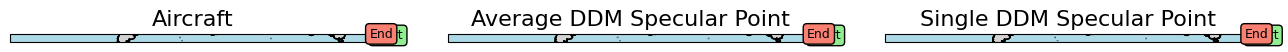

In [56]:
lat_lon_pairs = {
    'Aircraft': (f.variables['ac_lat'][:], f.variables['ac_lon'][:]),
    'Average DDM Specular Point': (np.nanmean(specular_point_lat, axis=1), np.nanmean(specular_point_lon, axis=1)),
    'Single DDM Specular Point': (np.compress(~np.isnan(np.array(specular_point_lat).ravel()), np.array(specular_point_lat).ravel()),
                                  np.compress(~np.isnan(np.array(specular_point_lon).ravel()), np.array(specular_point_lon).ravel())),
}

min_lat = float(np.array([float(np.nanmin(lat_lon_pairs[pair][0])) for pair in lat_lon_pairs]).min())
max_lat = float(np.array([float(np.nanmax(lat_lon_pairs[pair][0])) for pair in lat_lon_pairs]).max())

min_lon = float(np.array([float(np.nanmin(lat_lon_pairs[pair][1])) for pair in lat_lon_pairs]).min())
max_lon = float(np.array([float(np.nanmax(lat_lon_pairs[pair][1])) for pair in lat_lon_pairs]).max())

# Creare la figura con una proiezione geografica
fig, ax = plt.subplots(1, 3, figsize=(16, 24), subplot_kw={"projection": ccrs.PlateCarree()})

for i, pair in enumerate(lat_lon_pairs):

        # Get the latitude and longitude of the aircraft
        lats = np.array(lat_lon_pairs[pair][0])
        lons = np.array(lat_lon_pairs[pair][1])

        # Aggiungere le caratteristiche della mappa
        pad = 3
        ax[i].set_extent([min_lon-pad, max_lon+pad, min_lat-pad, max_lat+pad], crs=ccrs.PlateCarree())
        ax[i].add_feature(cfeature.OCEAN, facecolor="lightblue")
        ax[i].add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
        ax[i].add_feature(cfeature.COASTLINE)

        # Disegnare la rotta
        ax[i].scatter(lons, lats, marker="o", color="blue", s=2, linewidth=1, transform=ccrs.PlateCarree())

        # Etichettare inizio e fine
        ax[i].text(lons[0], lats[0], "Start", color="black", fontsize=9, transform=ccrs.PlateCarree(),
                bbox=dict(facecolor="lightgreen", edgecolor="black", boxstyle="round,pad=0.3"))
        ax[i].text(lons[-1], lats[-1], "End", color="black", fontsize=9, transform=ccrs.PlateCarree(),
                bbox=dict(facecolor="salmon", edgecolor="black", boxstyle="round,pad=0.3"))
        ax[i].set_title(pair, fontsize=16)

# Mostrare la mappa
plt.show()


### Labelling Land vs Water

The Natural Earth Dataset lets us know whether the aircraft was flying over land or water at each timestamp, while Rongowai's "sp_surface_type" variable lets us know each single DDM's surface type (1 timestamp -> 20 DDMs; 1 aircraft surface type -> 20 DDM surface types). The antenna can be oriented in such a way to cover multiple surface types at each timestamp.

For the classification task, "sp_surface_type" is our target variable. It includes 8 classes (1 Ocean, 7 non-Ocean) but we are interested in a binary classification task (Sea vs. Land).

#### Natural Earth dataset

In [57]:
# Carica il dataset delle terre emerse (Natural Earth) https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
world = gpd.read_file("./data/land_vs_water_country_borders/ne_110m_admin_0_countries.shp")
lats = np.array(lat_lon_pairs['Aircraft'][0])
lons = np.array(lat_lon_pairs['Aircraft'][1])

def is_land(lat, lon):
    """Restituisce True se il punto è su terra, False se è in mare/oceano"""
    point = Point(lon, lat)  # Geopandas usa (lon, lat), non (lat, lon)
    return any(world.contains(point))

# Esempio di utilizzo
for lat, lon in zip(lats[:10], lons[:10]):
    print(f"Lat: {lat}, Lon: {lon} → {'Terra' if is_land(lat, lon) else 'Mare'}")


Lat: -38.60580862248665, Lon: 177.90043255915518 → Terra
Lat: -38.605312207574045, Lon: 177.89966235805653 → Terra
Lat: -38.604814974249365, Lon: 177.89888622329318 → Terra
Lat: -38.60431421726266, Lon: 177.89811010065958 → Terra
Lat: -38.60381345595562, Lon: 177.89733399015574 → Terra
Lat: -38.603315395158994, Lon: 177.89655194584535 → Terra
Lat: -38.602813707280205, Lon: 177.89576417836614 → Terra
Lat: -38.60230849534822, Lon: 177.89497642305318 → Terra
Lat: -38.60179975929575, Lon: 177.89418867990642 → Terra
Lat: -38.6012881074655, Lon: 177.89339542478535 → Terra


In [58]:
# Contare quanti punti sono su terra e quanti in mare
land_points = sum([is_land(lat, lon) for lat, lon in zip(lats, lons)])
water_points = len(lats) - land_points
print('Land points:', land_points)
print('Water points:', water_points)

# Trova almeno un paio di punti su terra e su mare
a_few_land_points = np.random.choice([i for i, val in enumerate([is_land(lat, lon) for lat, lon in zip(lats, lons)]) if val], 5)
a_few_water_points = np.random.choice([i for i, val in enumerate([is_land(lat, lon) for lat, lon in zip(lats, lons)]) if not val], 5)

Land points: 2608
Water points: 138


#### Rongowai DDM surface types (from LINZ database)

<class 'netCDF4.Variable'>
float32 sp_surface_type(sample, ddm)
    units: 1
    long_name: Surface type of the specular point
    comment: Surface type of the specular point, surface type from the latest LINZ database, where
-1 = ocean, 1 = artifical, 2 = barely vegetated, 3 = inland water, 4 = crop, 5 = grass, 6 = shrub, 7 = forest
unlimited dimensions: sample, ddm
current shape = (2746, 20)
filling on, default _FillValue of 9.969209968386869e+36 used


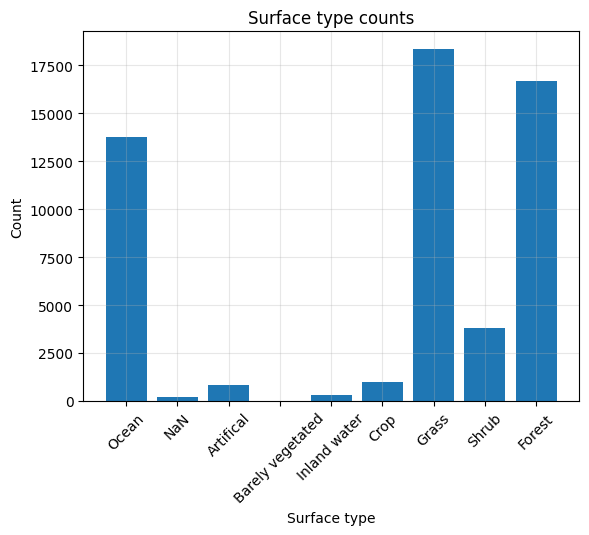

In [59]:
# DDM specular point surface types
from collections import Counter

print(f.variables["sp_surface_type"])

surface_type_dict = {
    -1:"Ocean",
    0:"NaN",
    1:"Artifical",
    2:"Barely vegetated",
    3:"Inland water",
    4:"Crop",
    5:"Grass",
    6:"Shrub",
    7:"Forest"
}

# Conteggio delle occorrenze
surface_types = f.variables["sp_surface_type"][:]
surface_types = np.nan_to_num(surface_types, nan=0)
counts = Counter(np.array(surface_types).ravel())
surface_type_labels = list(counts.keys())
freqs = list(counts.values())

plt.bar(surface_type_labels, freqs)
plt.xlabel('Surface type')
plt.ylabel('Count')
plt.xticks(ticks=list(surface_type_dict.keys()), labels=surface_type_dict.values(), rotation=45)
plt.title('Surface type counts')
plt.grid(alpha=0.3)
plt.show()

In [60]:
# NOTE: there are samples for which the 20 DDMs have different surface types - due to antenna orientations? Yes

np.array(surface_types[-10:])

array([[-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -

In [61]:
# Check whether a group of 20 DDMs has at least one ocean and one land point
def check_ocean_and_land(lst):
    has_ocean = -1 in lst
    has_land = any(1 <= num <= 7 for num in lst)
    #if has_ocean and has_land:
    #    print(f"Sample {lst} has at least one ocean and one land point")
    return has_ocean and has_land

samples_have_ocean_and_land = [check_ocean_and_land(lst) for lst in surface_types]
print(f"Samples with at least one ocean and one land point: {sum(samples_have_ocean_and_land)}")



Samples with at least one ocean and one land point: 1841


## DDM plots

In [62]:
a_few_land_points, a_few_water_points

(array([2455, 1450, 1382,  737, 2228]), array([1221, 1176, 1738, 1145, 1127]))

In [63]:
samples = [int(i) for i in np.concatenate((a_few_land_points, a_few_water_points))]

In [64]:
f.variables['raw_counts']

<class 'netCDF4.Variable'>
uint32 raw_counts(sample, ddm, delay, doppler)
    units: 1
    long_name: DDM bin raw counts
    comment: 5 x 40 array of DDM bin raw counts multiplies the first scale factor. These are the uncalibrated power values produced by the NGRx.
unlimited dimensions: sample, ddm, delay, doppler
current shape = (2746, 20, 40, 5)
filling on, default _FillValue of 4294967295 used

#### L1a Power DDM

5 x 40 array of DDM bin power, Watts. 

La variabile 'L1 Power DDM' è un array con dimensioni (*N*, 20, 40, 5), dove:

- *N*: Rappresenta il numero totale di campioni temporali, con misurazioni effettuate approssimativamente ogni secondo durante il volo.

- 20: Indica il numero di canali di ricezione per ciascun campione temporale. In ogni secondo, vengono registrate 20 DDM distinte, corrispondenti a diversi canali di ricezione. Questi canali possono includere combinazioni di polarizzazioni (ad esempio, LHCP e RHCP) e antenne (nadir e zenit), ma per una comprensione dettagliata della configurazione specifica dei canali nel dataset Rongowai, è consigliabile consultare la documentazione ufficiale del dataset.

- 40 e 5: Rappresentano rispettivamente le dimensioni della Delay Doppler Map (DDM), con 40 bin di ritardo e 5 bin di Doppler, formando una mappa bidimensionale per ciascun canale e campione temporale.

Pertanto, la dimensione intermedia di 20 indica che per ogni secondo vengono acquisite 20 DDM, ciascuna proveniente da un canale di ricezione distinto. Questa struttura consente di analizzare le riflessioni dei segnali GNSS da diverse prospettive e polarizzazioni, offrendo una comprensione più completa delle caratteristiche della superficie terrestre o marina sottostante.

In [65]:
ddm_antennas = {
    0: 'None',
    1: 'Zenith',
    2: 'LHCP',
    3: 'RHCP',
}


In [66]:
# Aircraft position
lats = np.array(lat_lon_pairs['Aircraft'][0])
lons = np.array(lat_lon_pairs['Aircraft'][1])

In [67]:
data = f.variables["ddm_snr"][:,0]
np.count_nonzero(data > 0), np.count_nonzero(data <= 0), data.size, np.count_nonzero(np.isnan(data))

(942, 1602, 2746, 202)

In [68]:
raw_counts = f.variables['raw_counts']
raw_counts = np.array(raw_counts)

(2746, 20, 40, 5)
Min: 0.0
Max: 1.1517261e-12
NaNs: 49600 (0.45%)


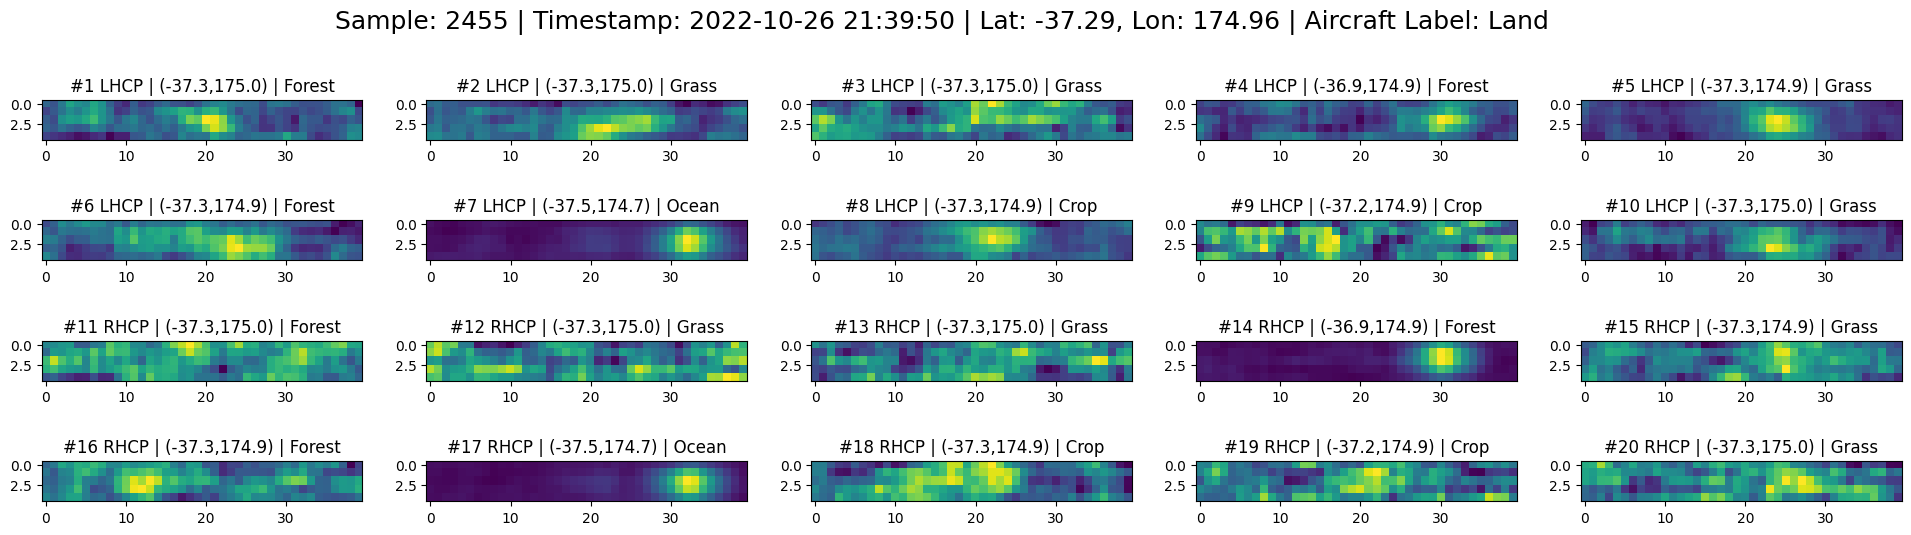

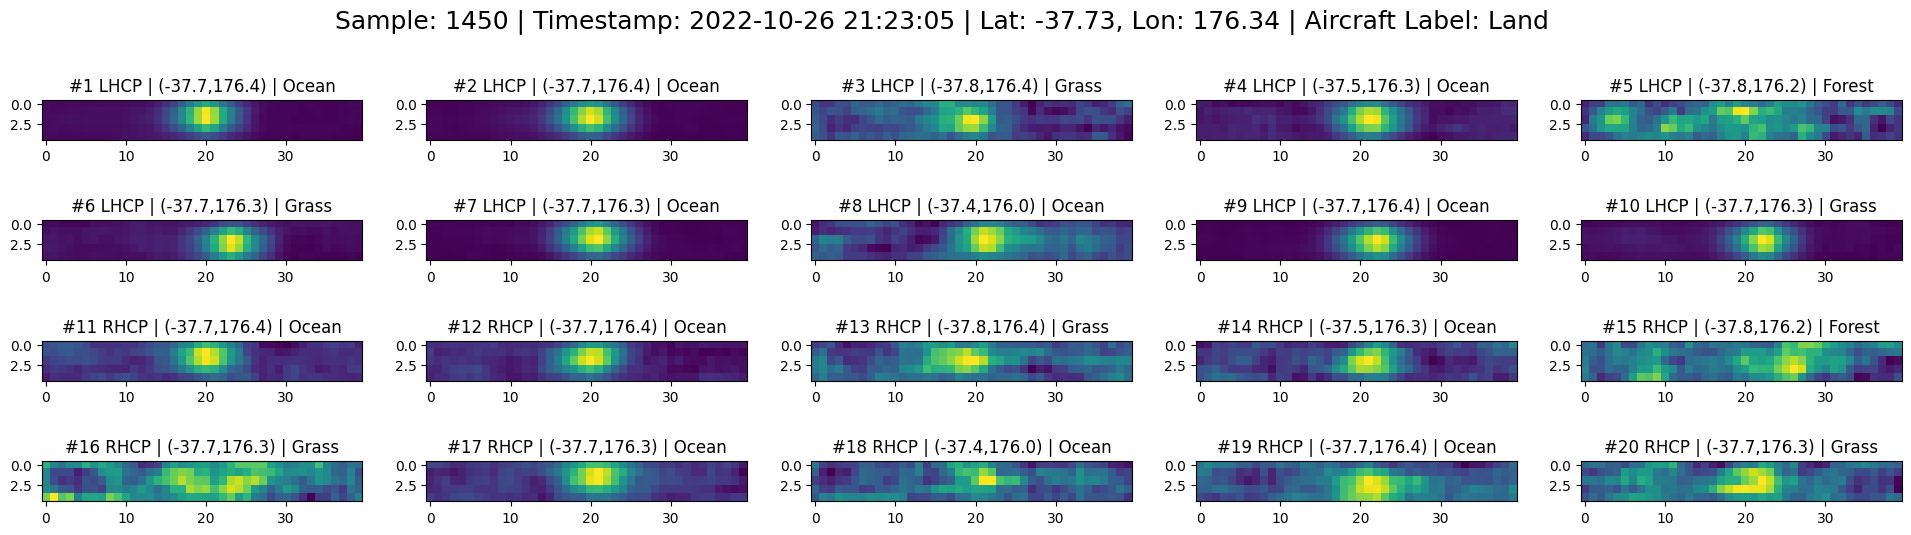

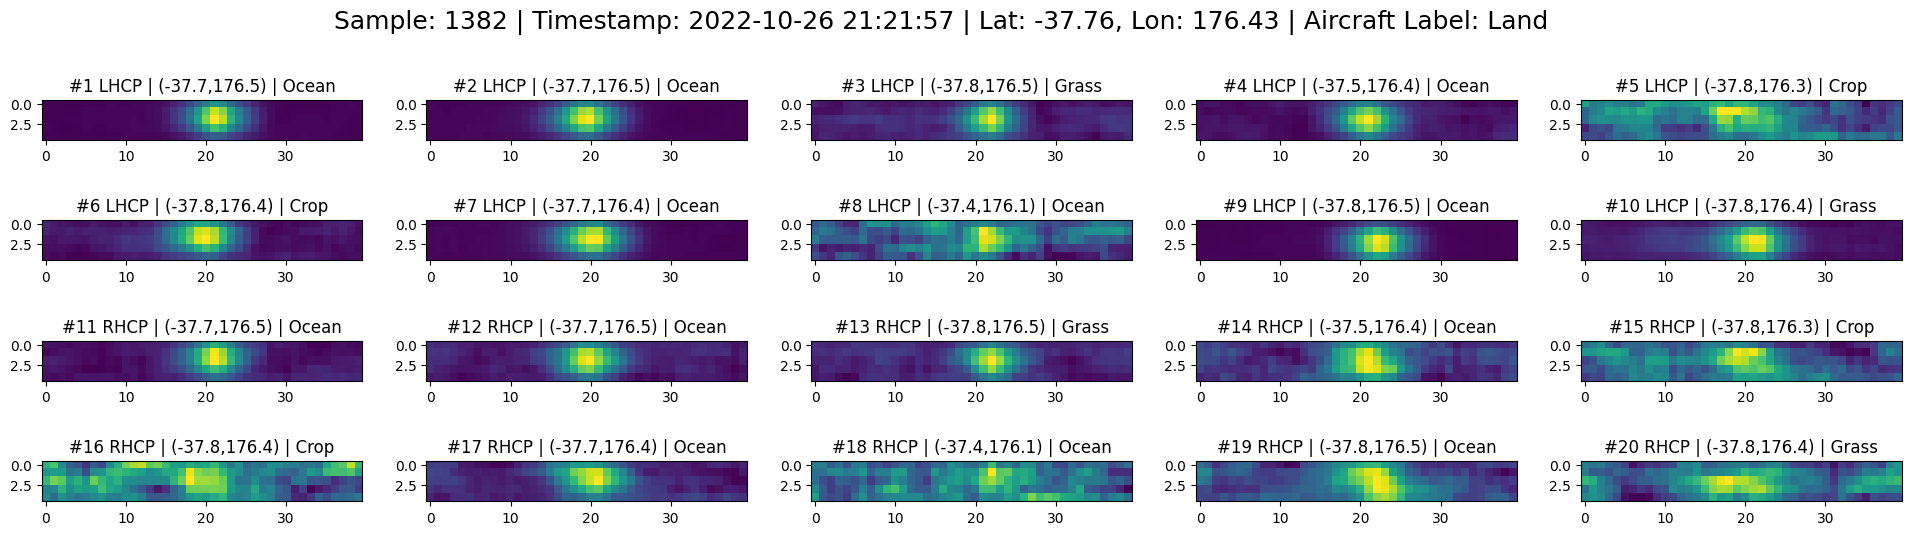

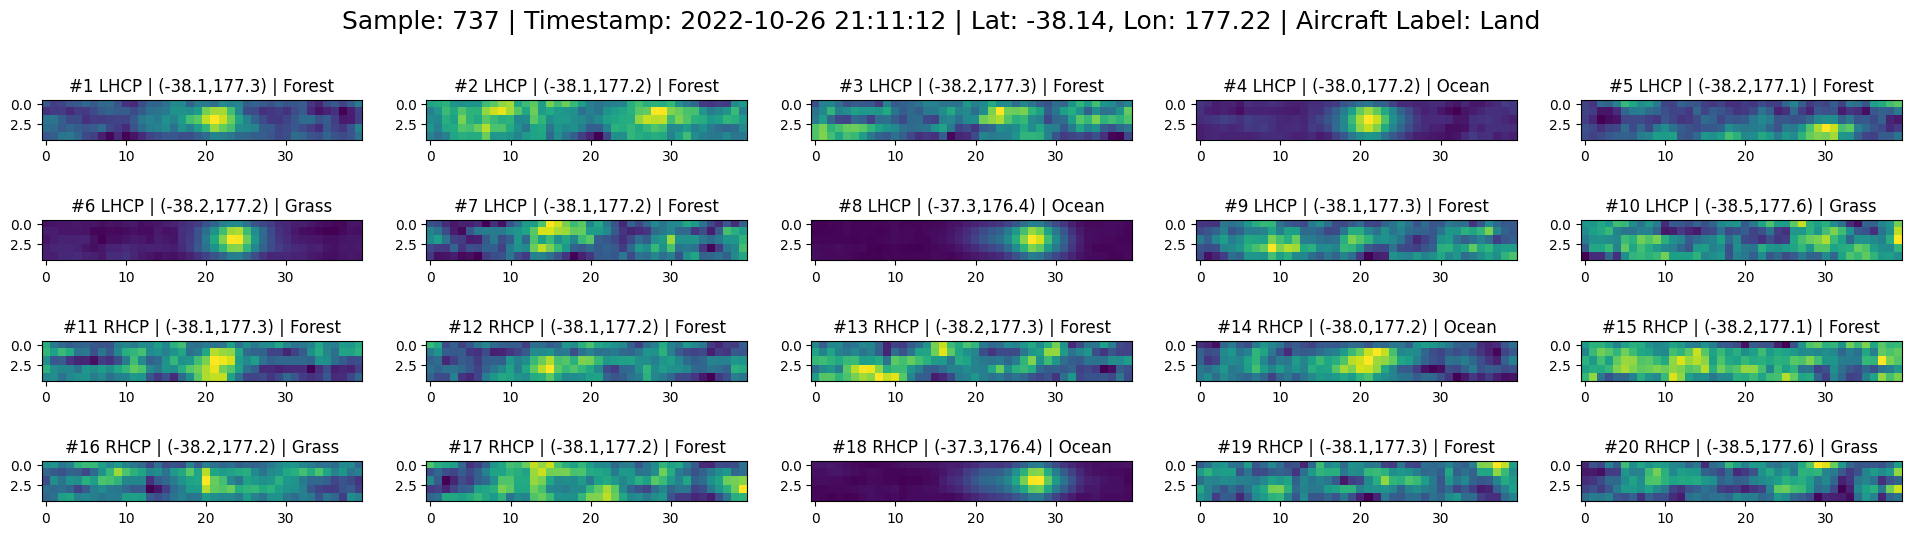

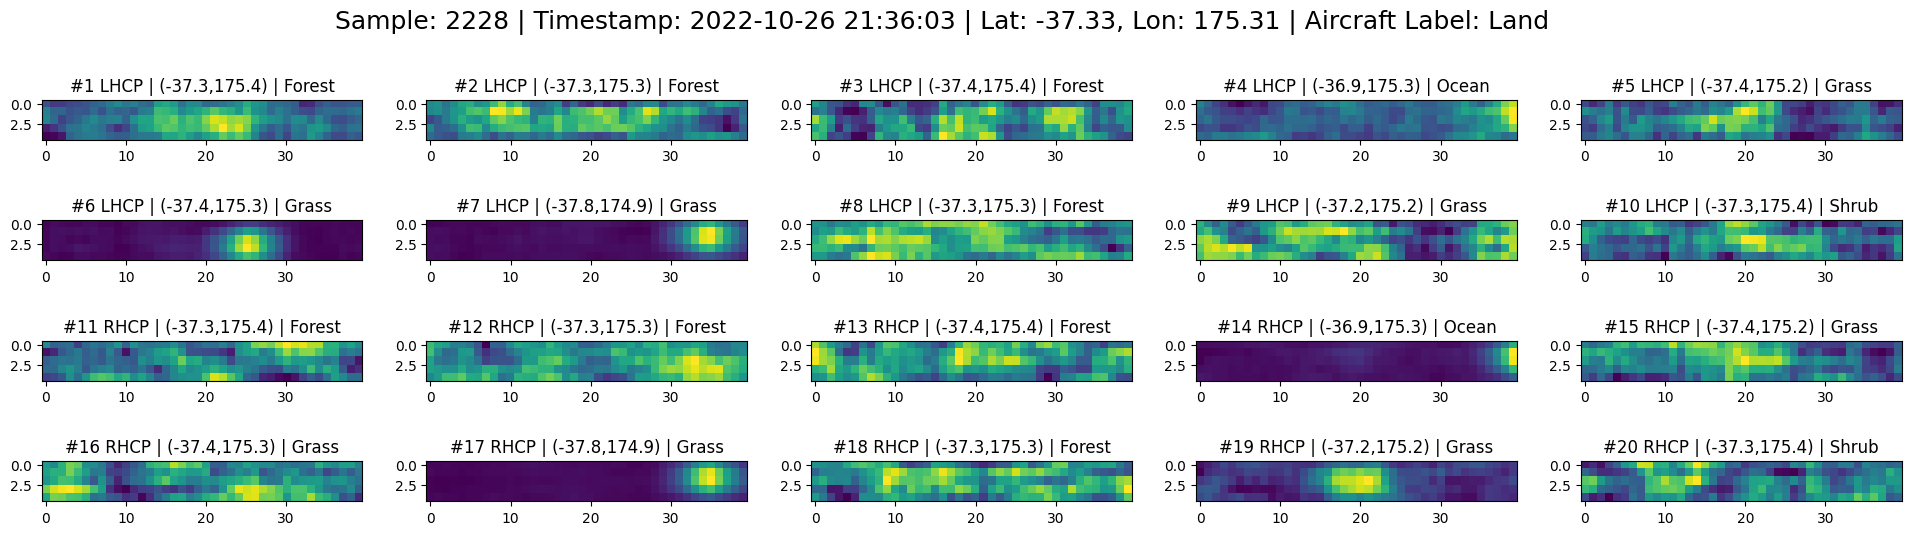

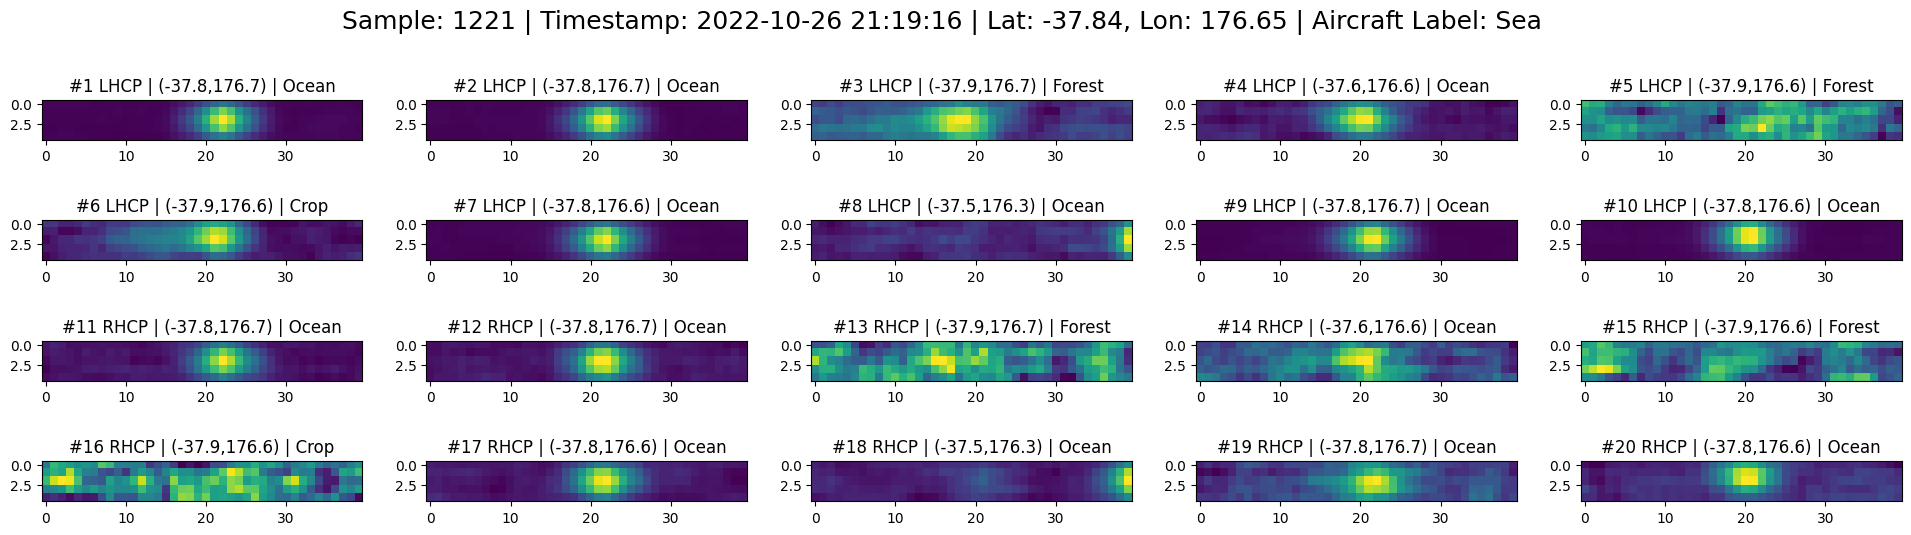

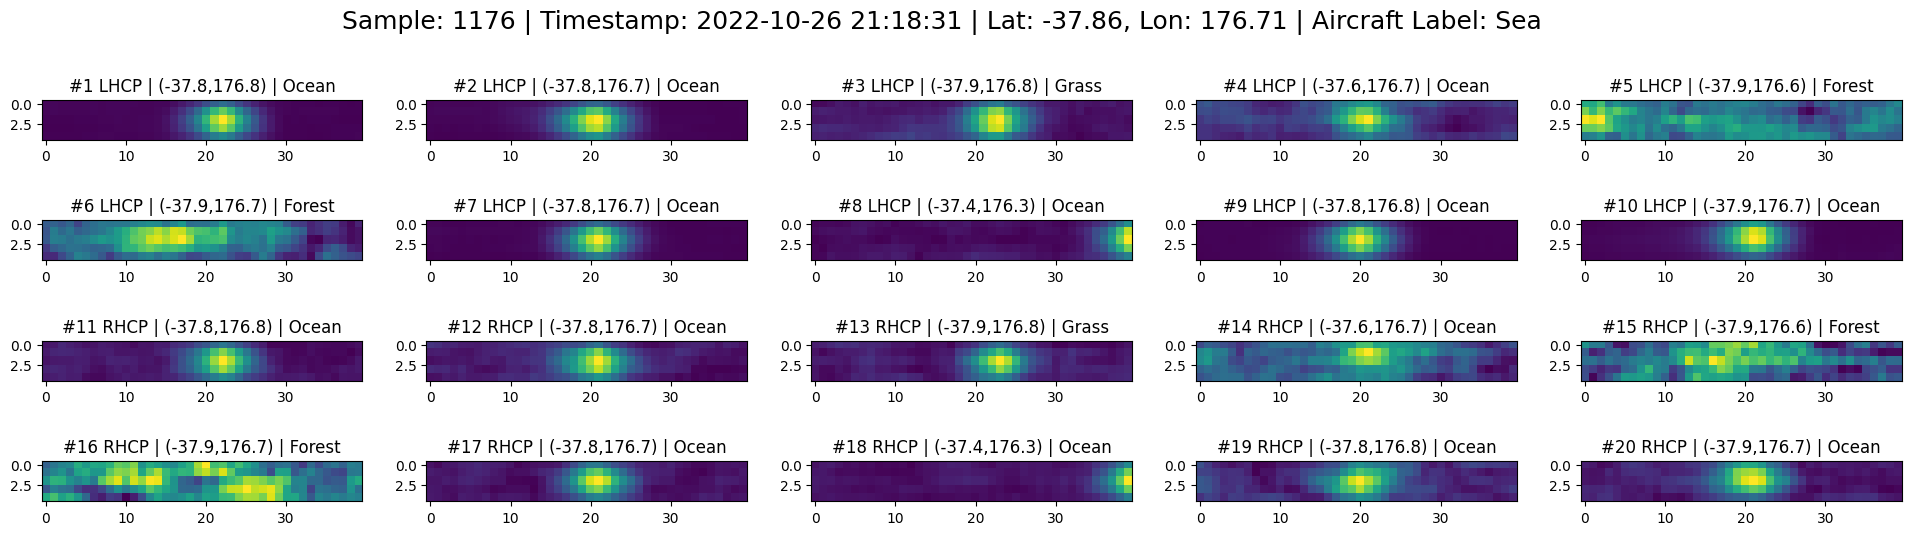

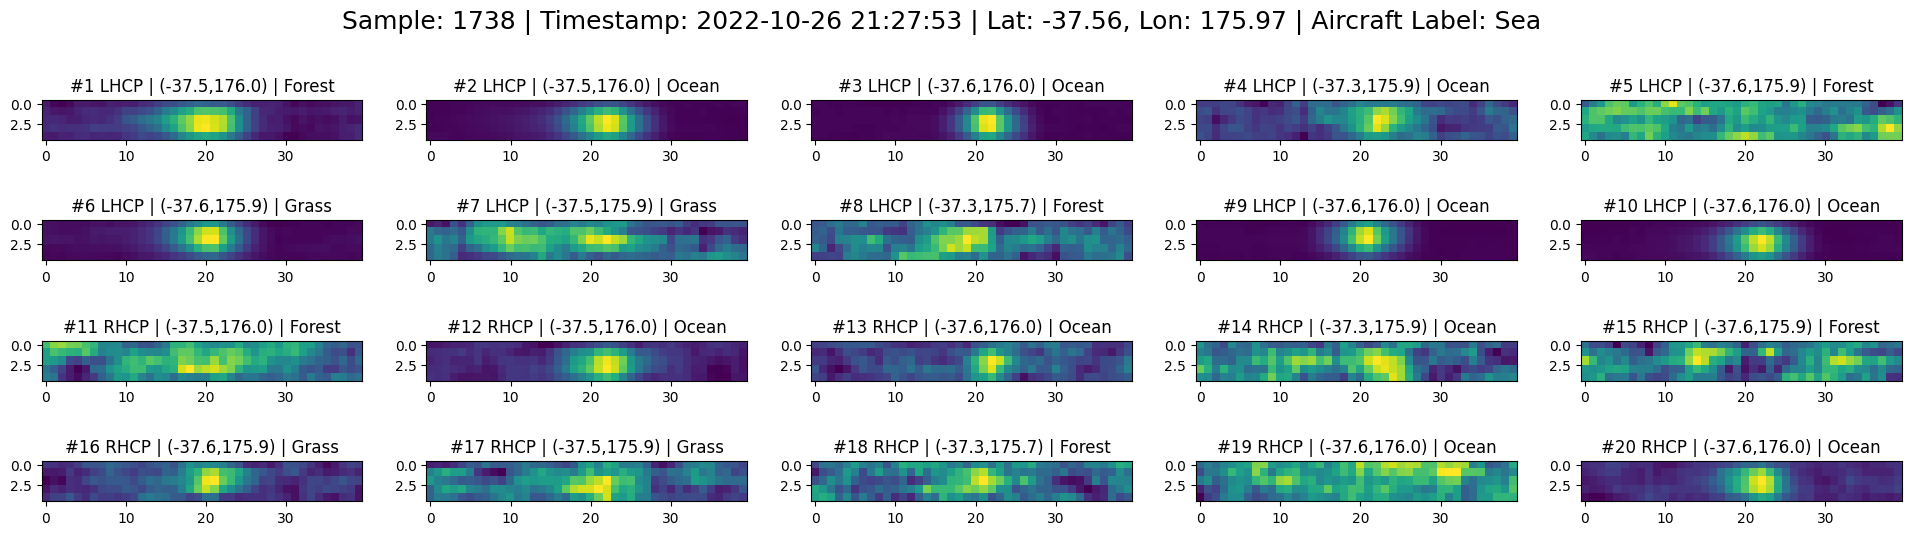

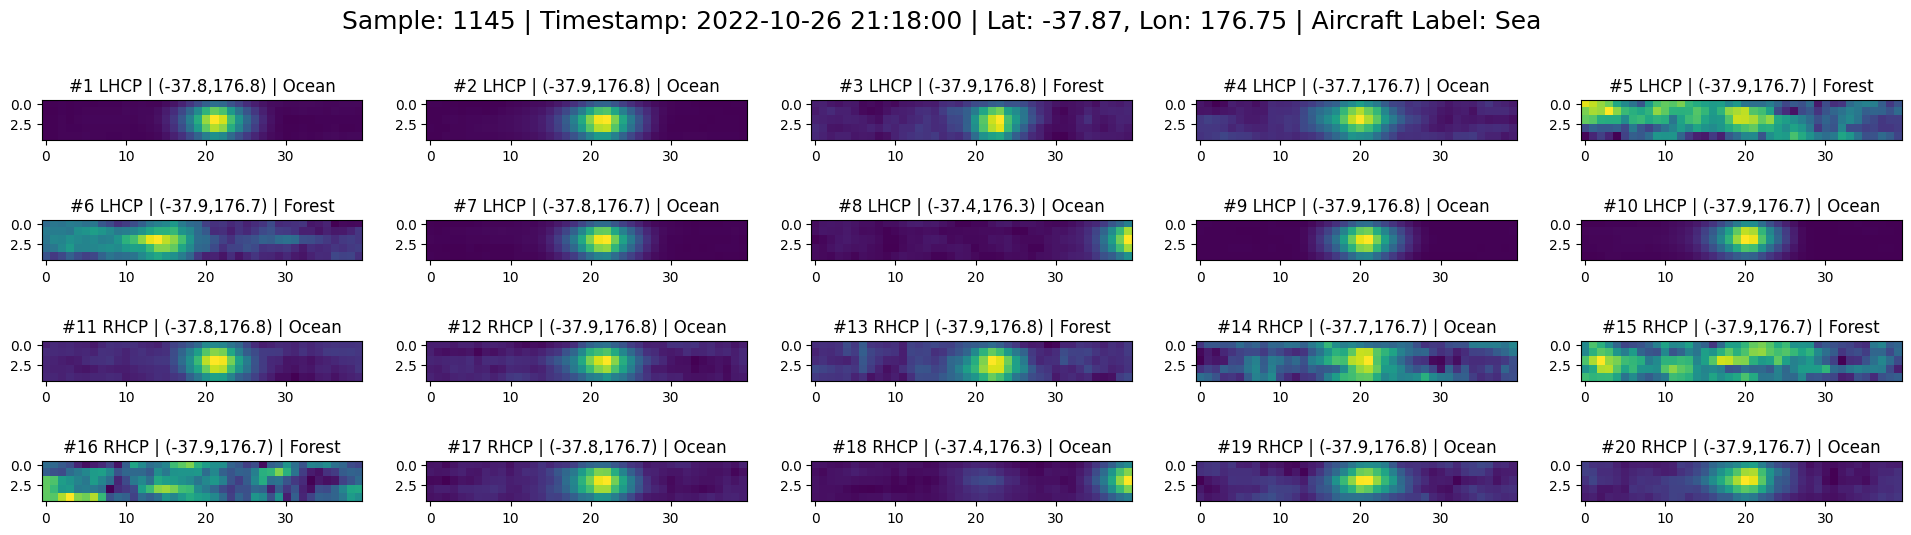

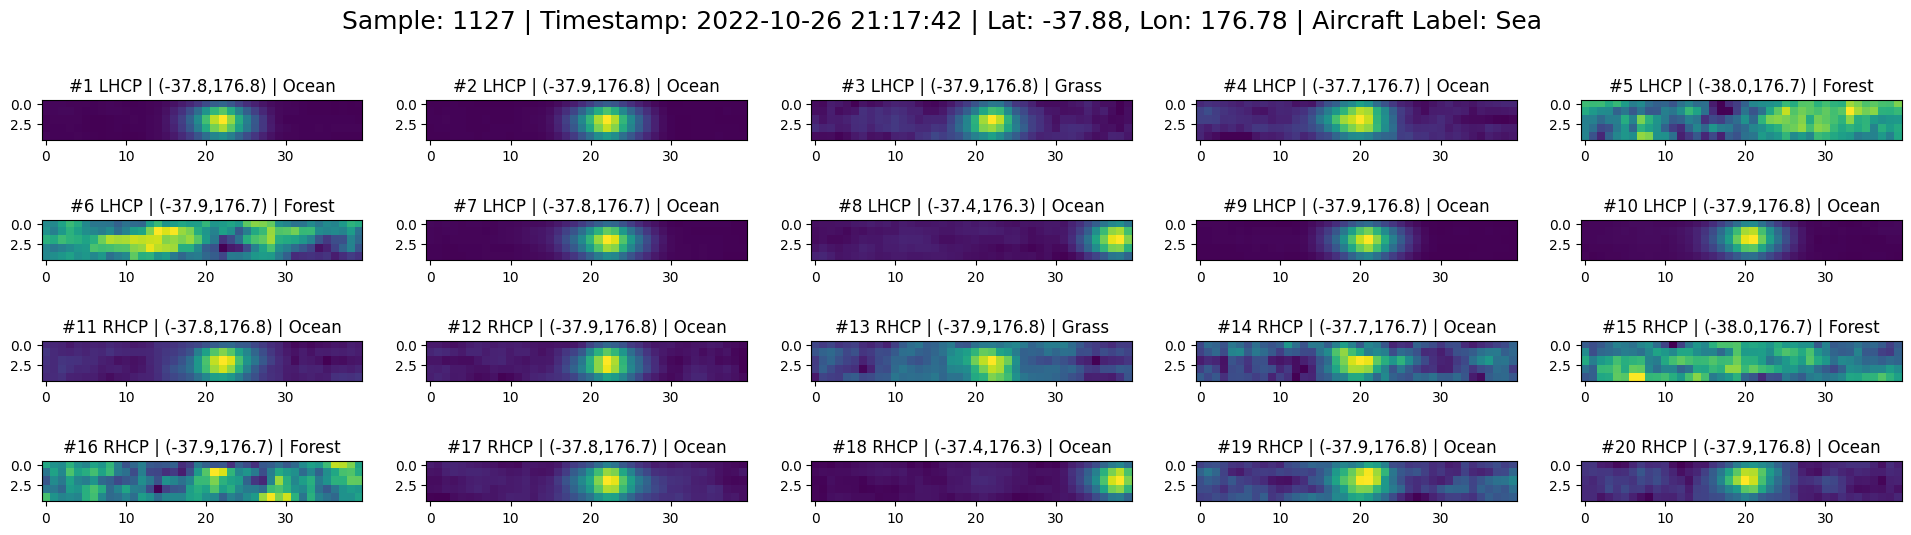

In [69]:
visualize = True

# Extracting and plotting DDMs
l1a_power_ddm = f.variables['L1a_power_ddm']
l1a_power_ddm = np.array(l1a_power_ddm)
print(l1a_power_ddm.shape)
print('Min:', np.nanmin(l1a_power_ddm))
print('Max:', np.nanmax(l1a_power_ddm))
print('NaNs:', np.count_nonzero(np.isnan(l1a_power_ddm)), '({:.2f}%)'.format(np.count_nonzero(np.isnan(l1a_power_ddm))/l1a_power_ddm.size*100))

if visualize:

    for sample in samples:

        plt.figure(figsize=(24,6))
        plt.suptitle(f"Sample: {sample} | Timestamp: {add_seconds(str(f.time_coverage_start), sample)} | Lat: {np.round(lats[sample], 2)}, Lon: {np.round(lons[sample], 2)} | Aircraft Label: {'Land' if is_land(lats[sample], lons[sample]) else 'Sea'}", fontsize=18)

        for ddm in range(l1a_power_ddm.shape[1]):

            antenna = f.variables['ddm_ant'][sample][ddm]

            plt.subplot(4, 5, ddm+1)
            plt.imshow(l1a_power_ddm[sample, ddm].T)
            plt.title(f"#{ddm+1} {ddm_antennas[antenna]} | ({np.round(specular_point_lat[sample,ddm],1)},{np.round(specular_point_lon[sample,ddm],1)}) | {surface_type_dict[int(surface_types[sample,ddm])]}", fontsize=12)

        plt.show()

### Raw counts

5 x 40 array of DDM bin raw counts multiplies the first scale factor. These are the uncalibrated power values produced by the NGRx.

(2746, 20, 40, 5)
Min: 0
Max: 1141940768
NaNs: 0 (0.00%)


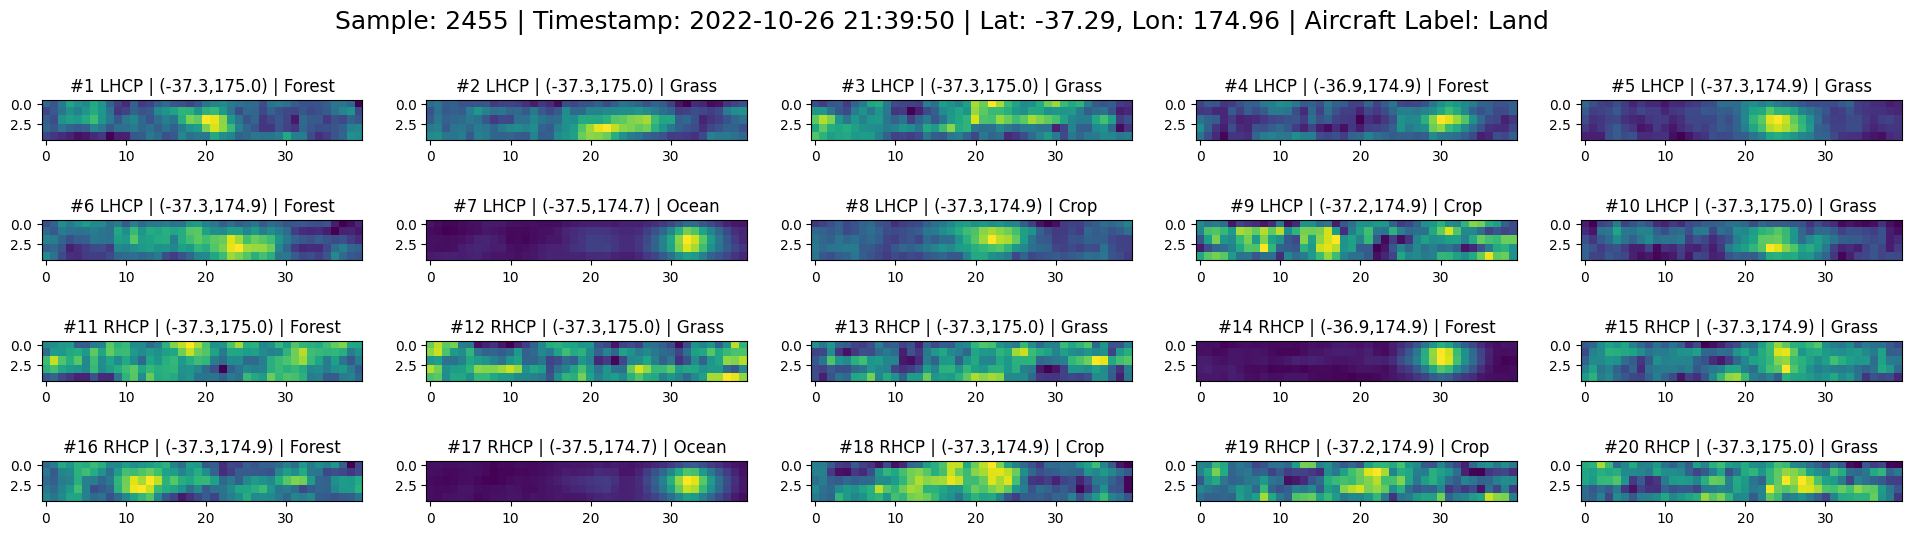

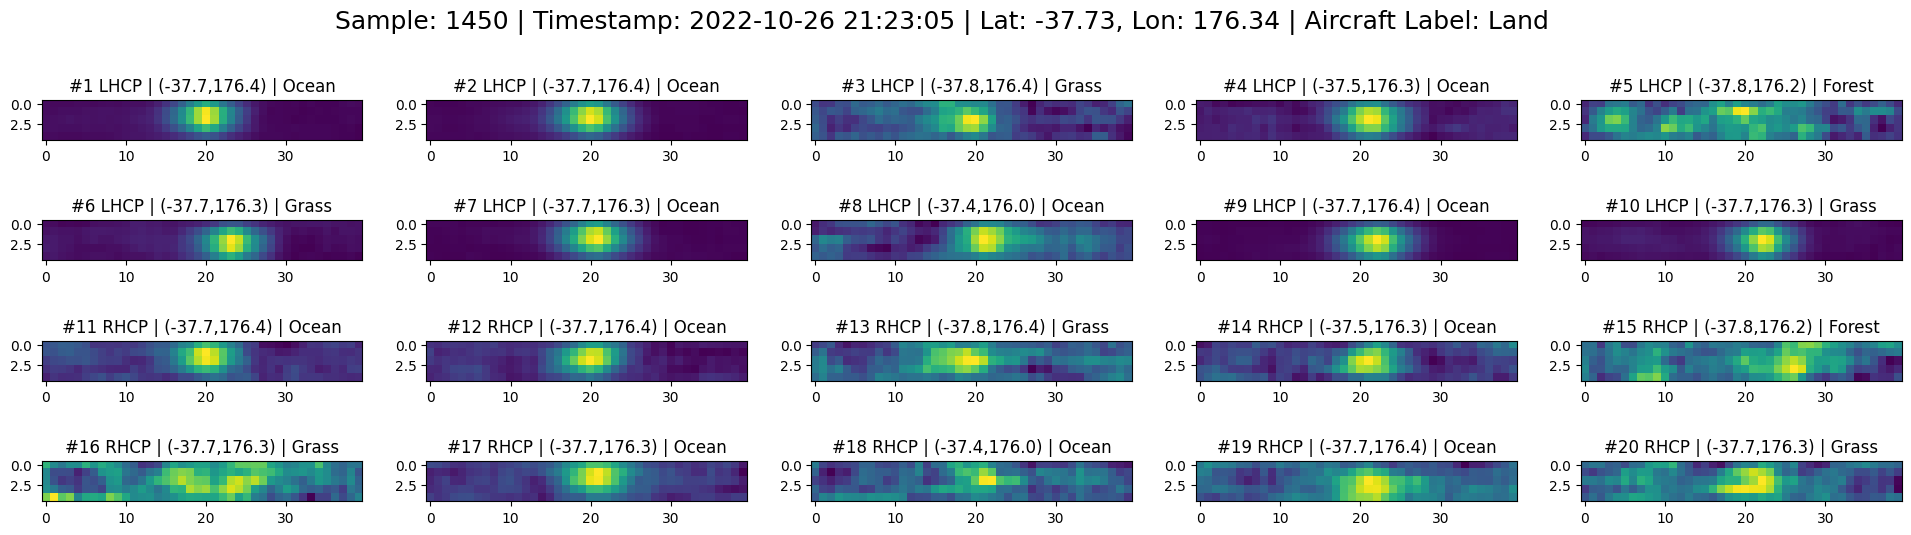

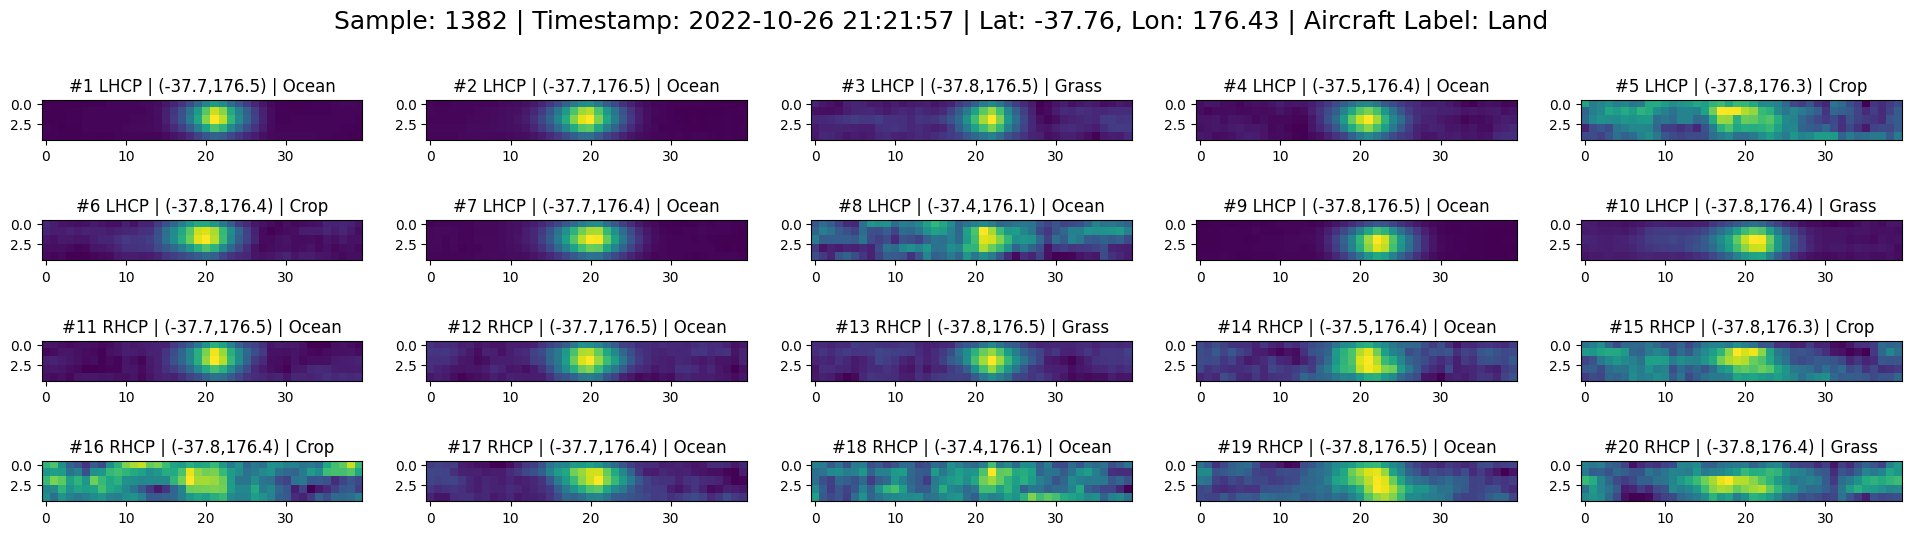

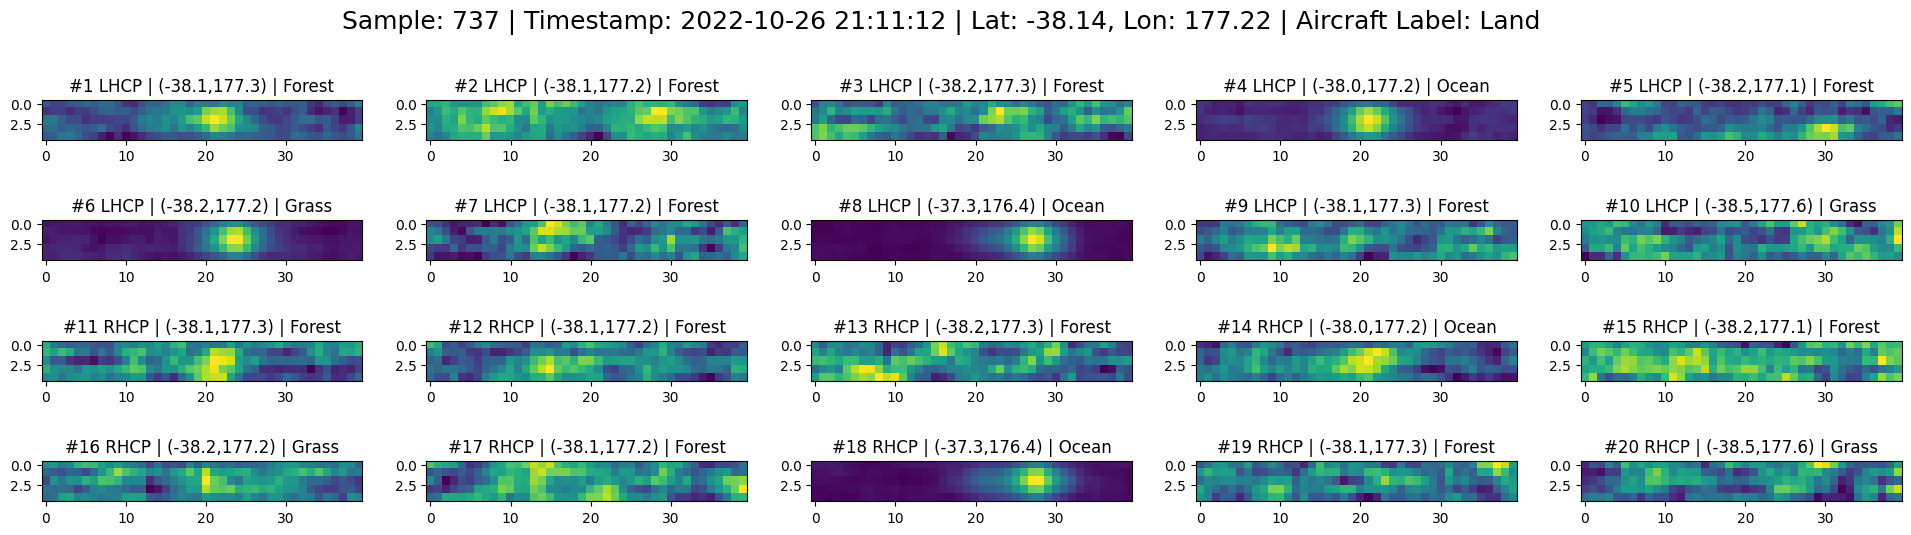

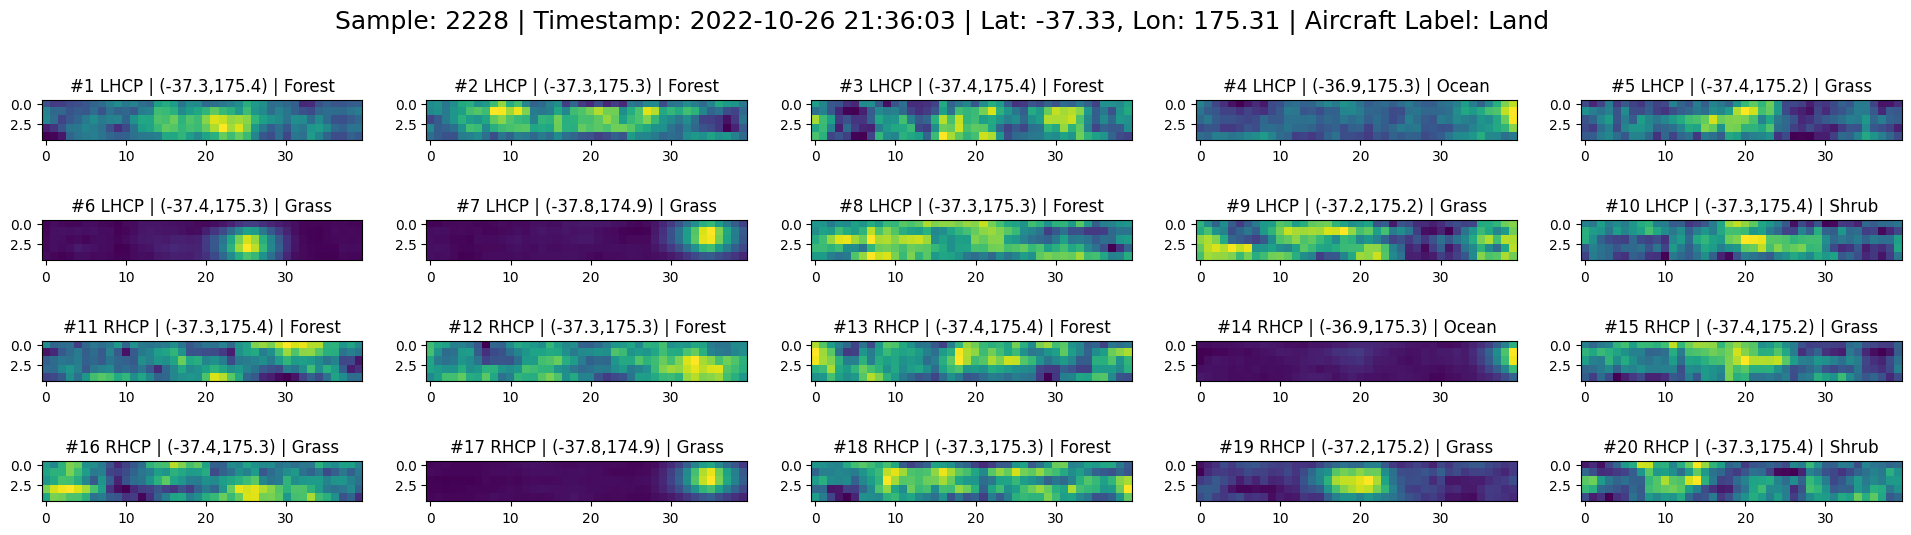

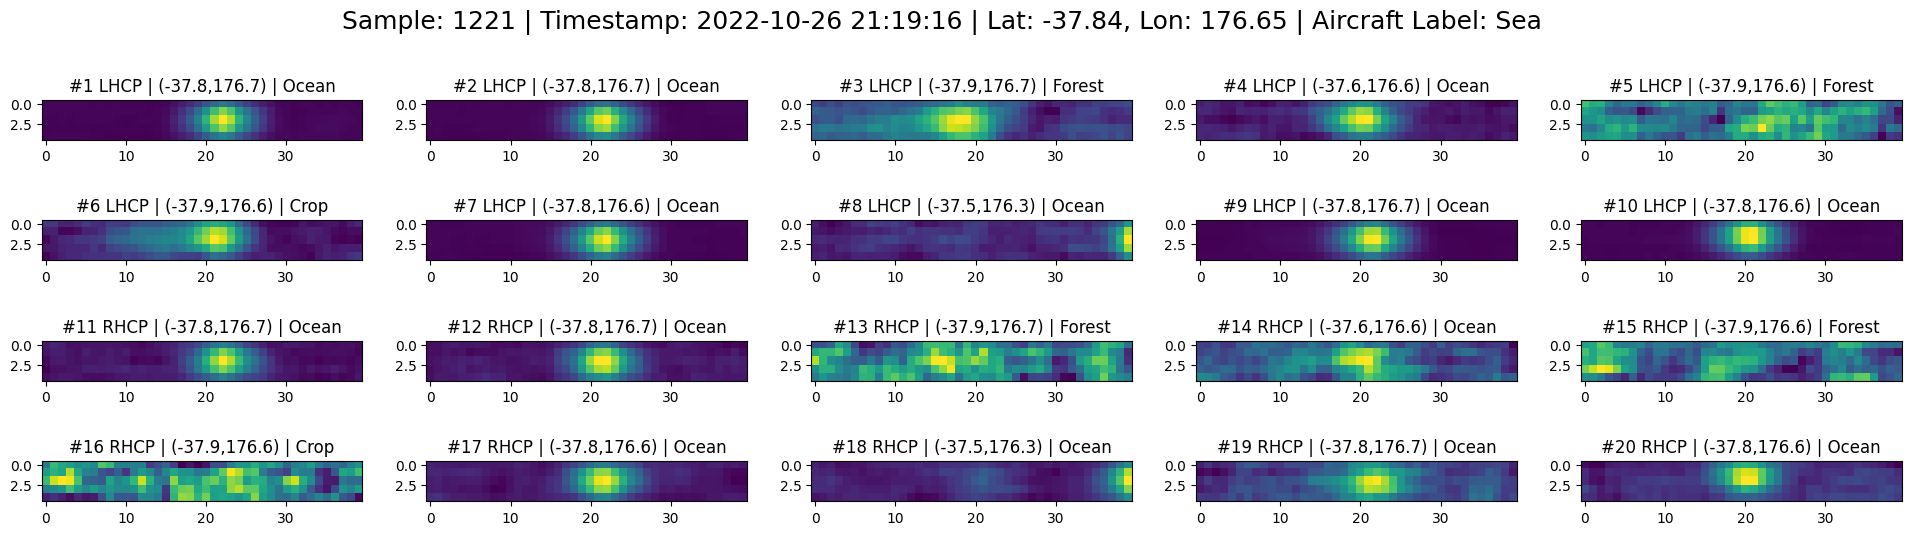

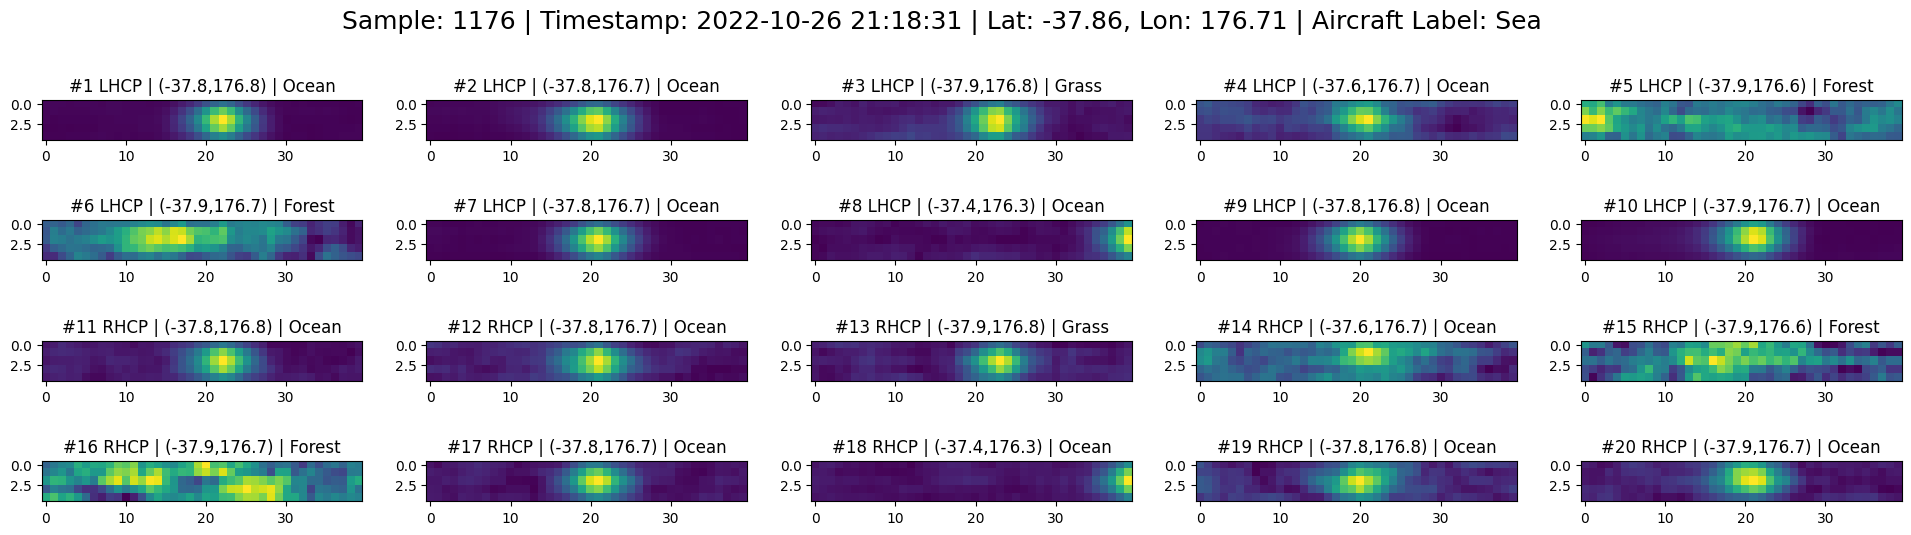

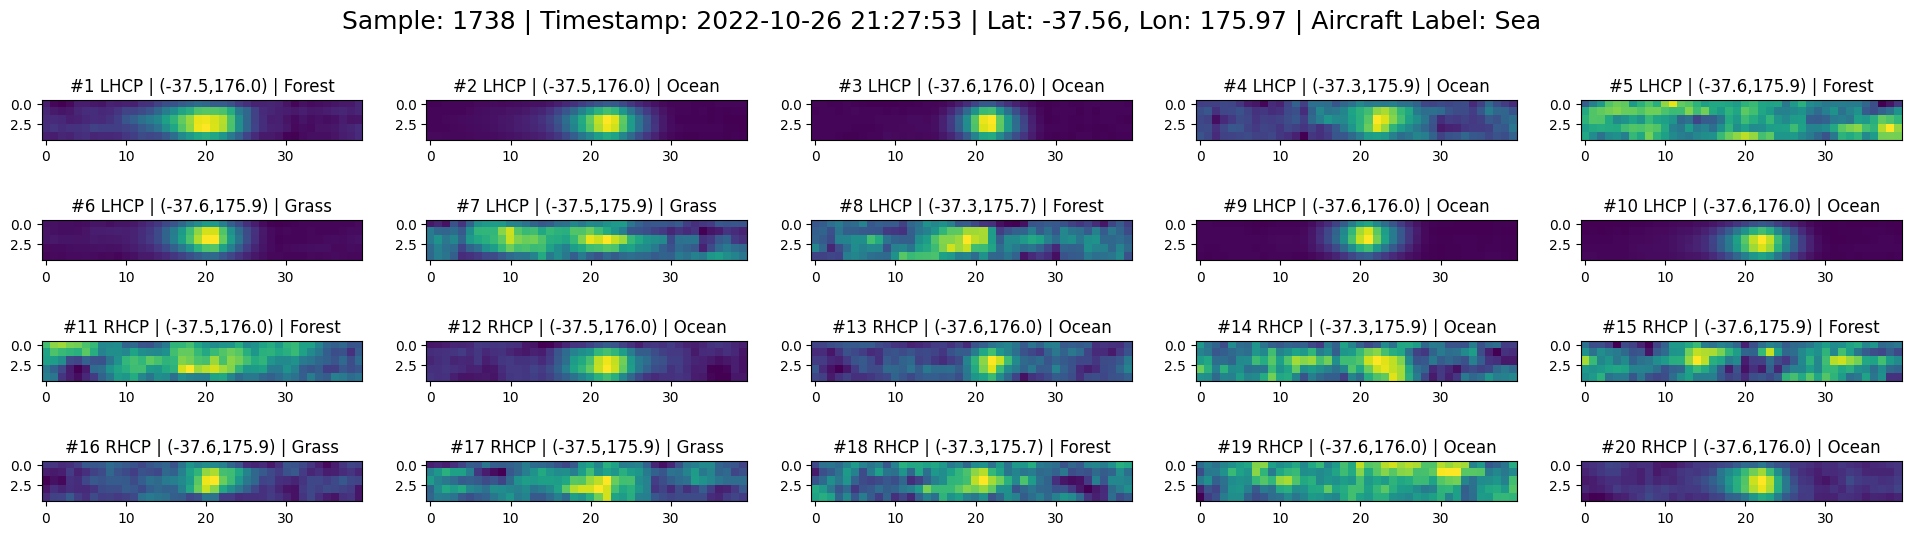

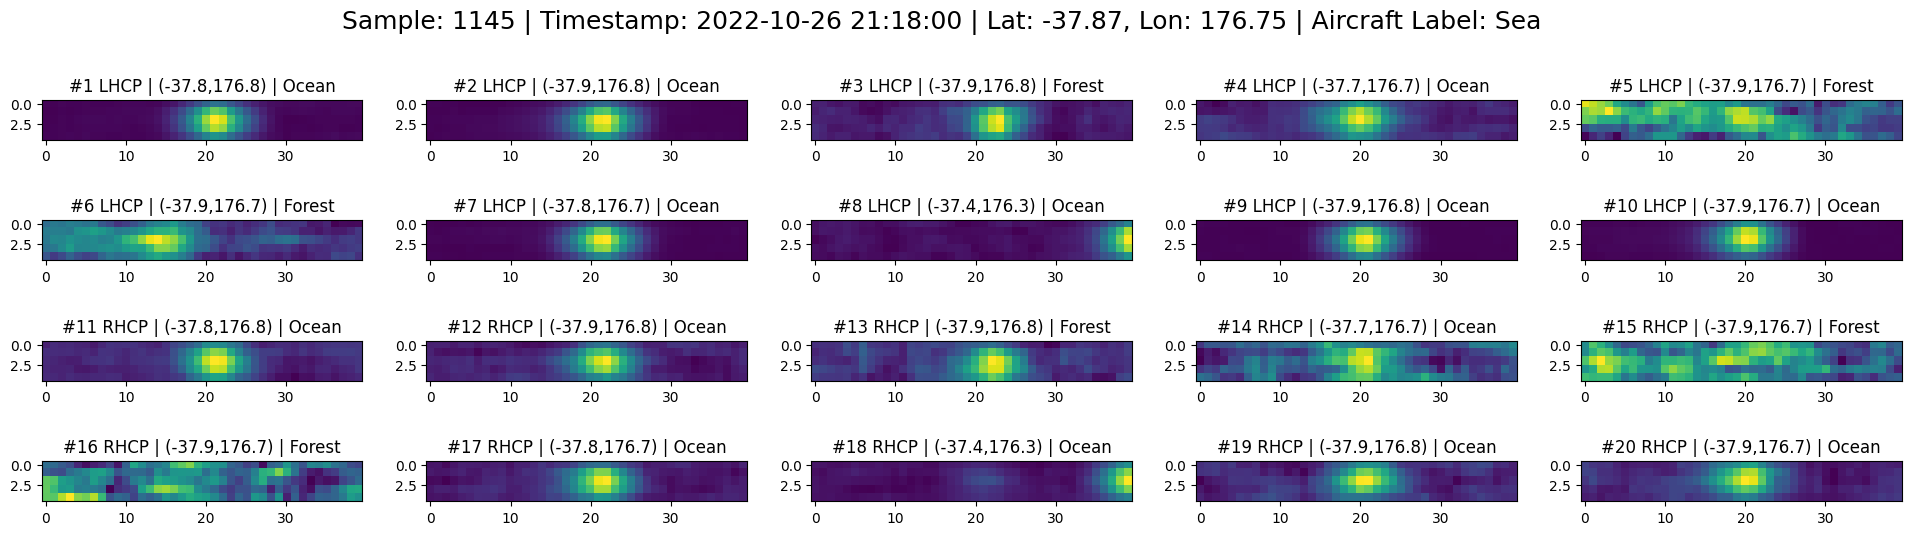

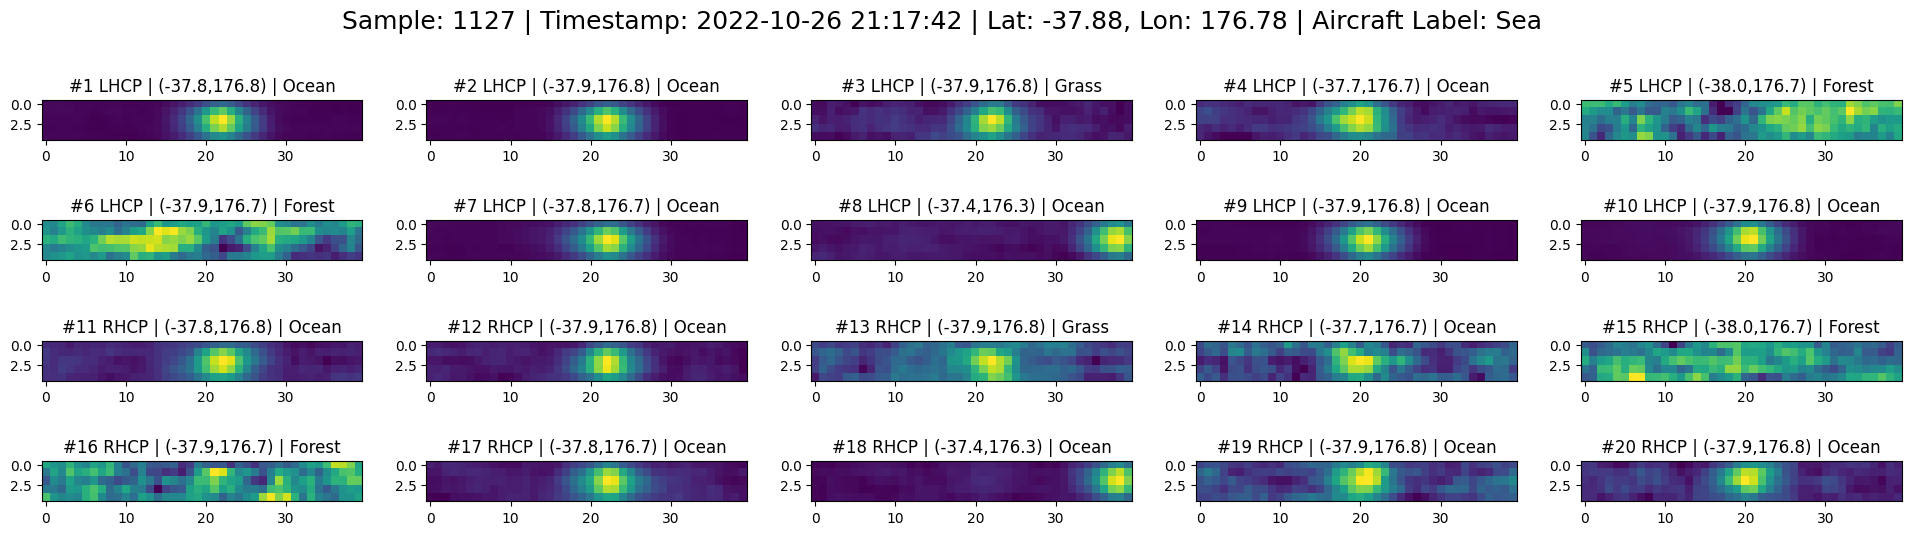

In [70]:
visualize = True

# Extracting and plotting DDMs
raw_counts = f.variables['raw_counts']
raw_counts = np.array(raw_counts)
print(raw_counts.shape)
print('Min:', np.nanmin(raw_counts))
print('Max:', np.nanmax(raw_counts))
print('NaNs:', np.count_nonzero(np.isnan(raw_counts)), '({:.2f}%)'.format(np.count_nonzero(np.isnan(raw_counts))/raw_counts.size*100))

if visualize:

    for sample in samples:

        plt.figure(figsize=(24,6))
        plt.suptitle(f"Sample: {sample} | Timestamp: {add_seconds(str(f.time_coverage_start), sample)} | Lat: {np.round(lats[sample], 2)}, Lon: {np.round(lons[sample], 2)} | Aircraft Label: {'Land' if is_land(lats[sample], lons[sample]) else 'Sea'}", fontsize=18)

        for ddm in range(raw_counts.shape[1]):

            antenna = f.variables['ddm_ant'][sample][ddm]

            plt.subplot(4, 5, ddm+1)
            plt.imshow(raw_counts[sample, ddm].T)
            plt.title(f"#{ddm+1} {ddm_antennas[antenna]} | ({np.round(specular_point_lat[sample,ddm],1)},{np.round(specular_point_lon[sample,ddm],1)}) | {surface_type_dict[int(surface_types[sample,ddm])]}", fontsize=12)

        plt.show()

### BRCS

5 x 40 array of DDM bin bistatic radar cross section, m^2. The specular point is located in DDM bin round(brcs_ddm_sp_bin_delay_row), round(brcs_ddm_sp_bin_dopp_col ).

(2746, 20, 40, 5)
Min: -210163730000.0
Max: 263158810000.0
NaNs: 50800 (0.46%)


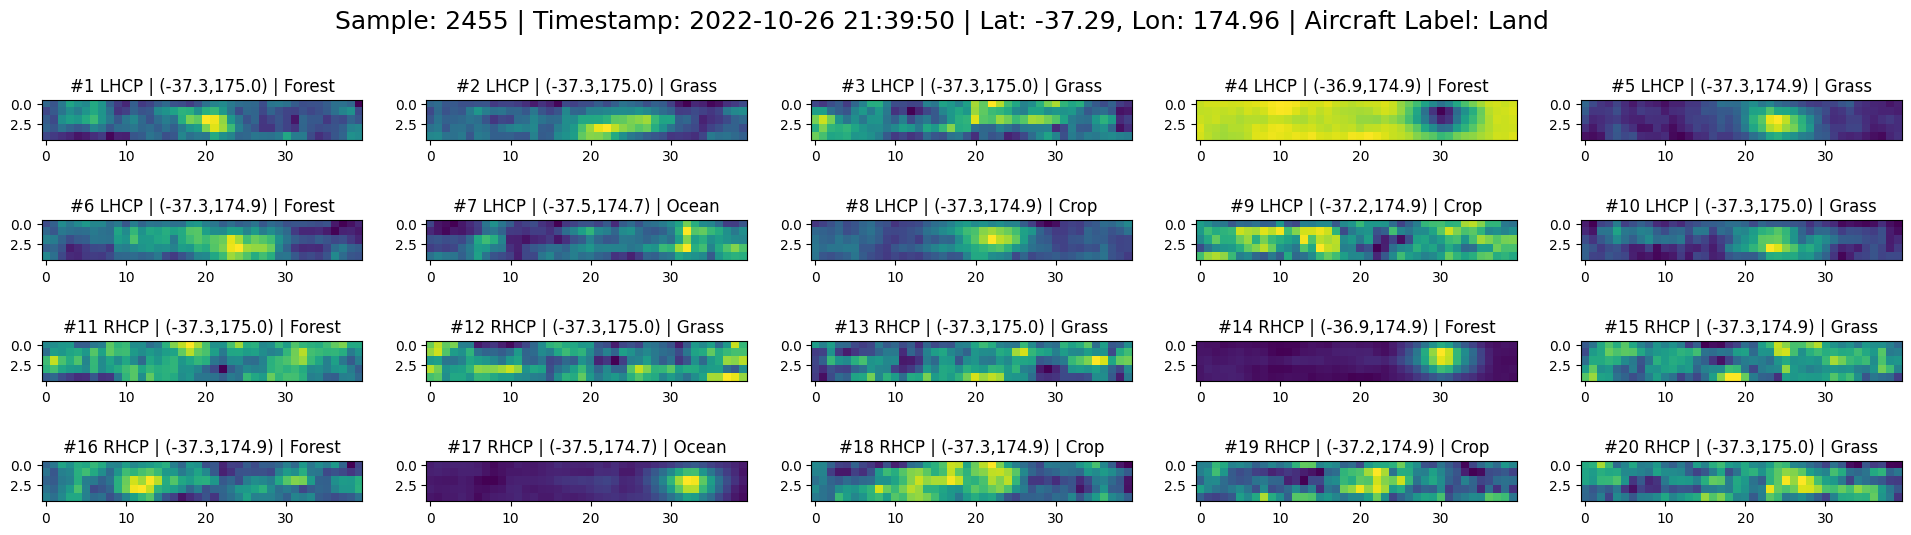

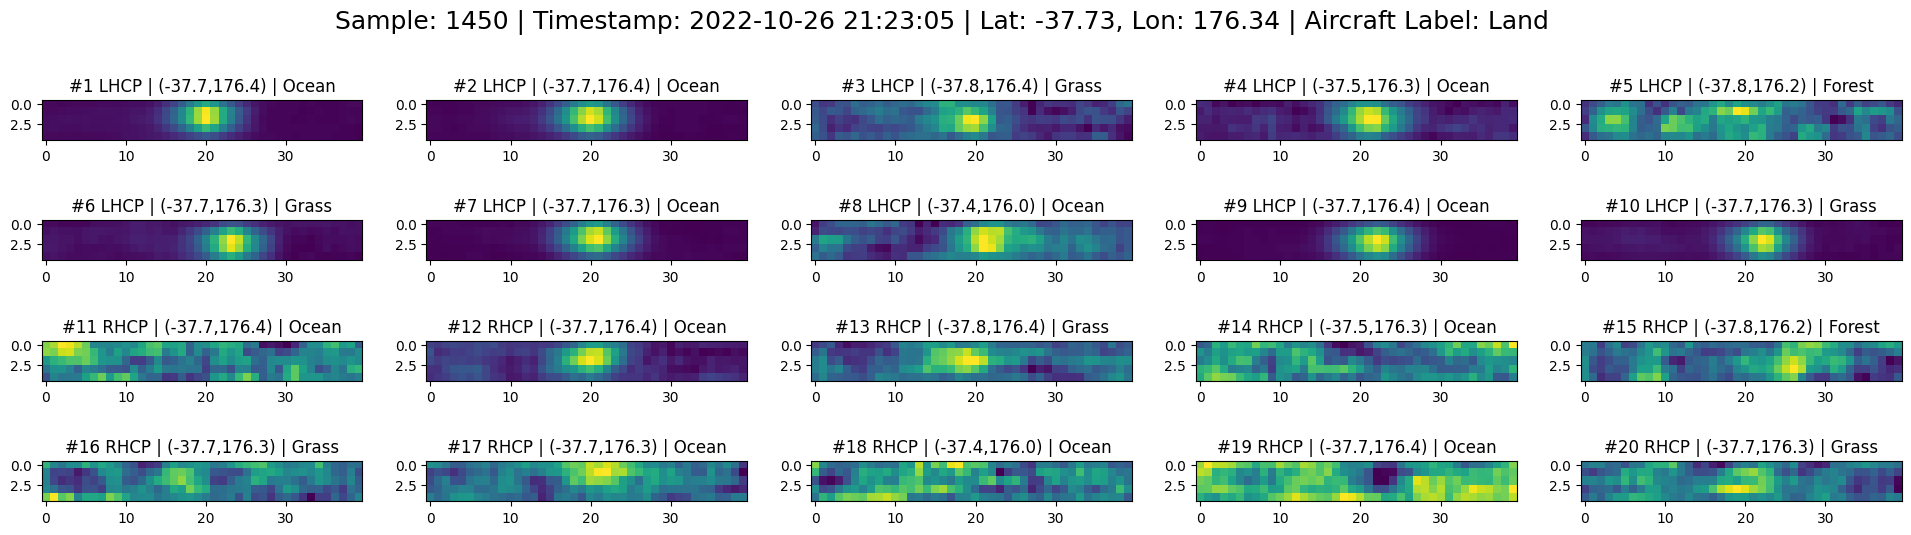

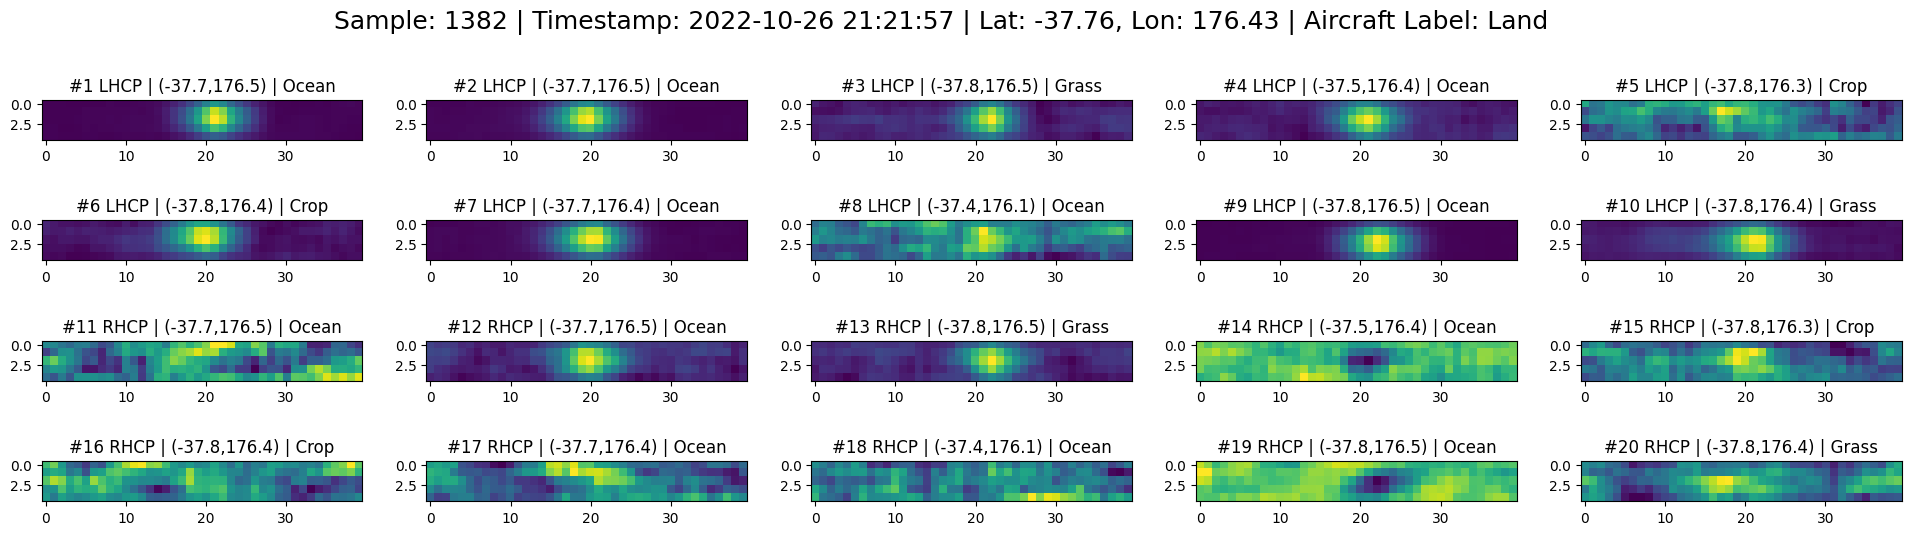

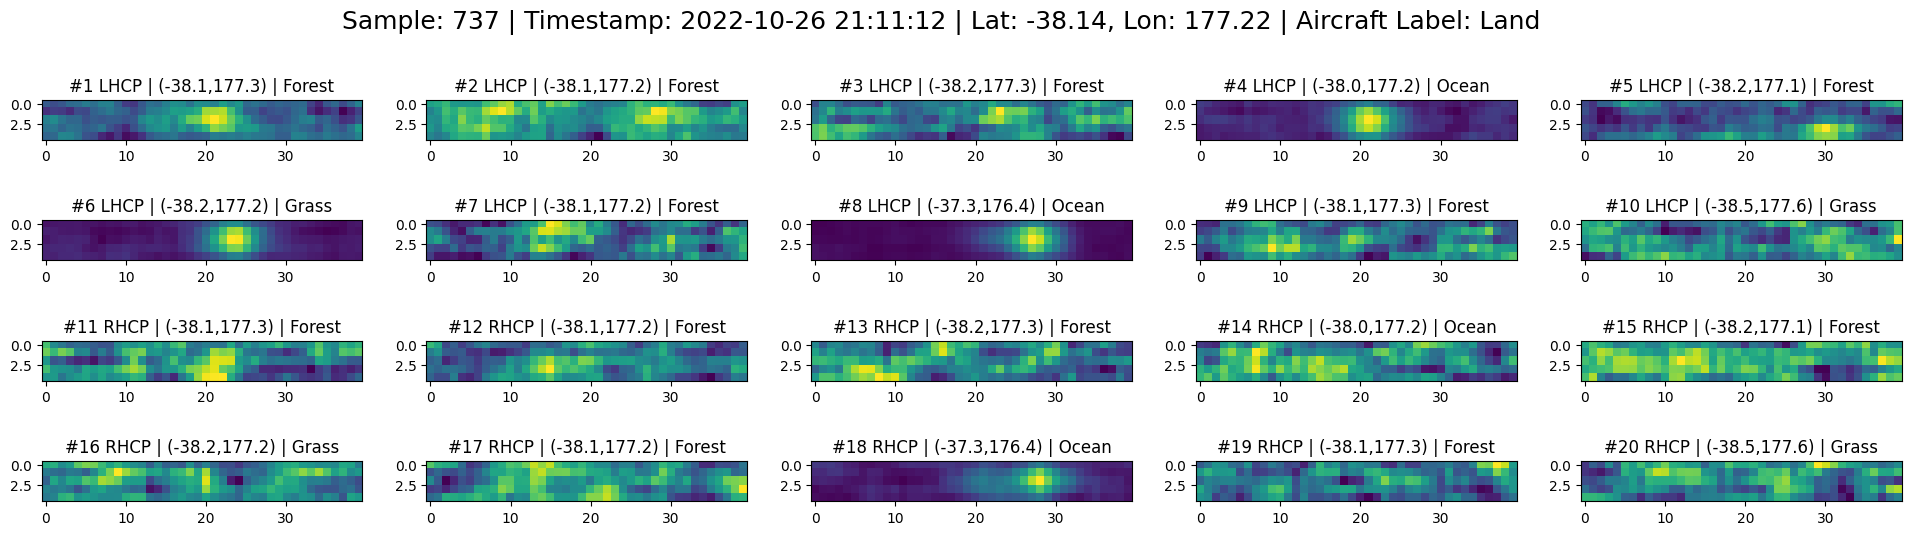

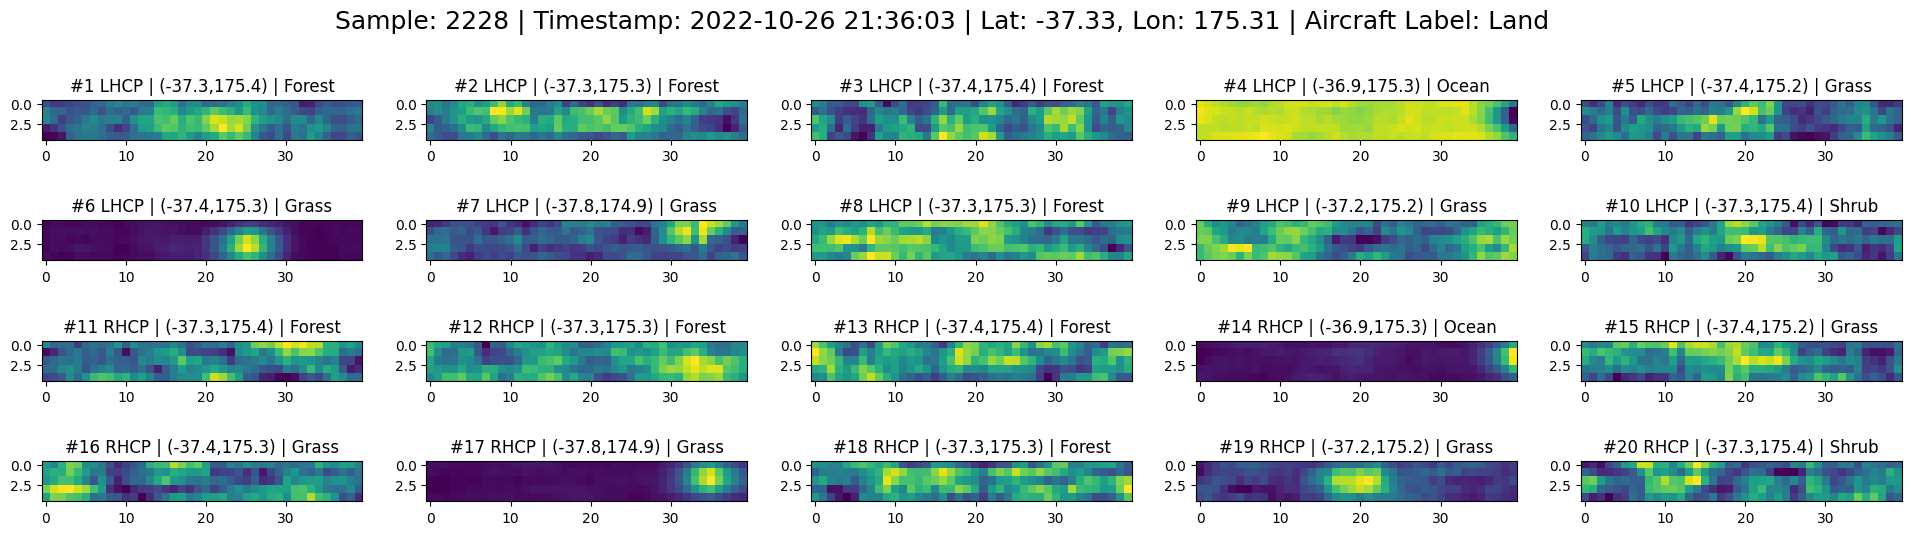

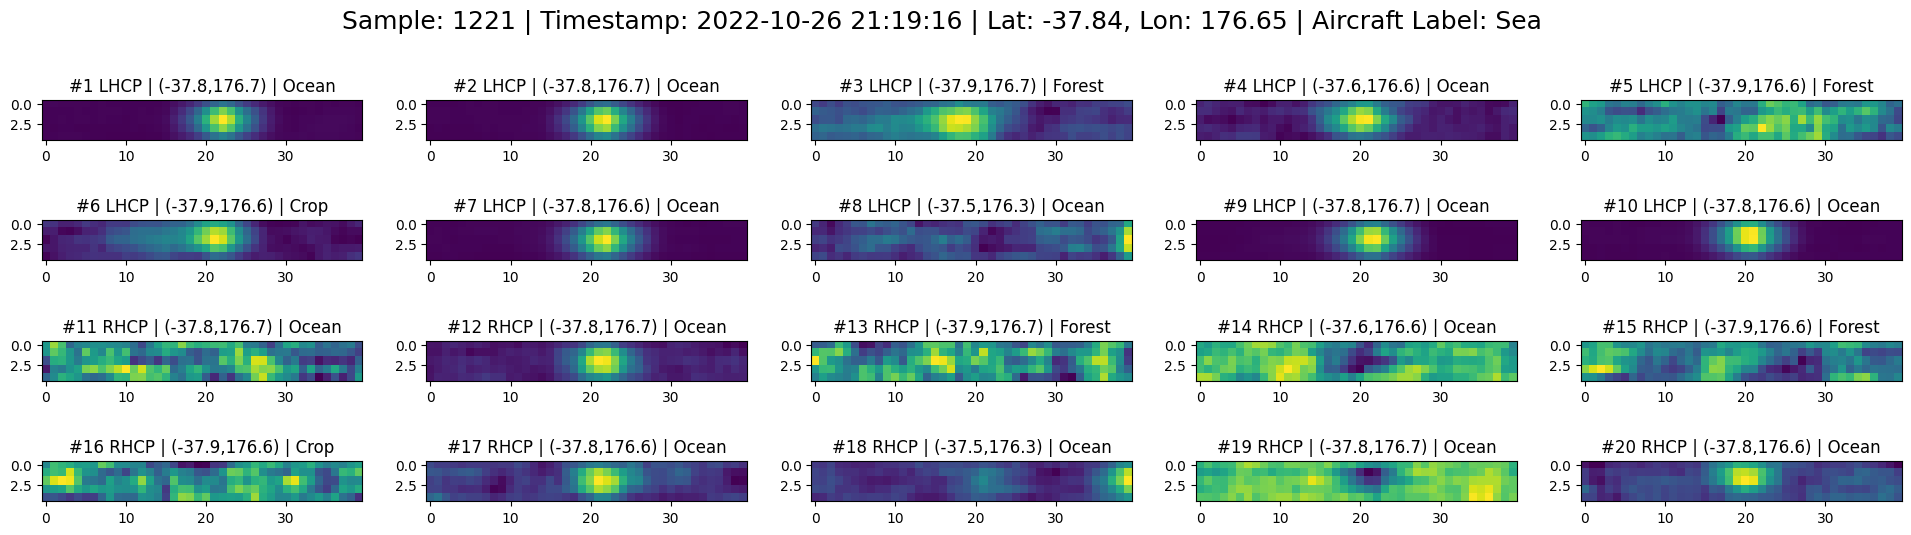

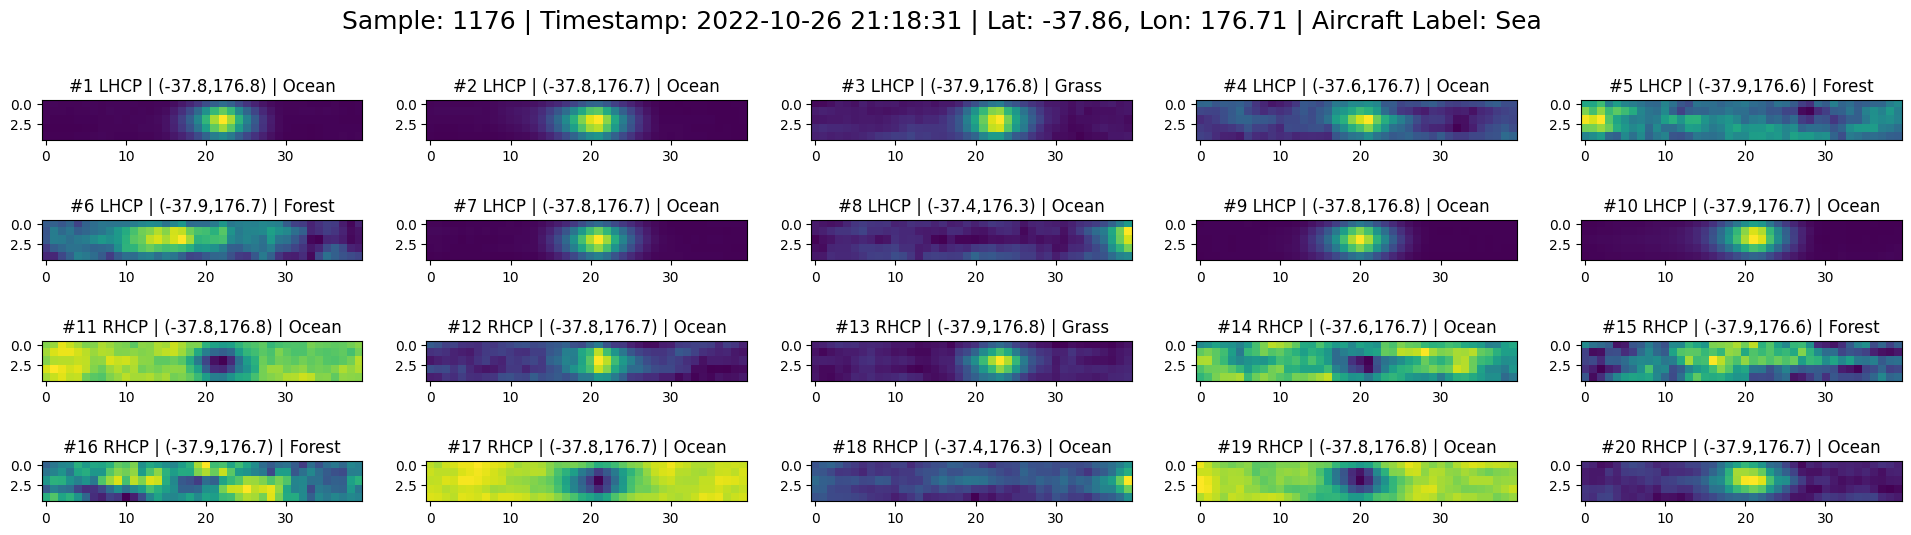

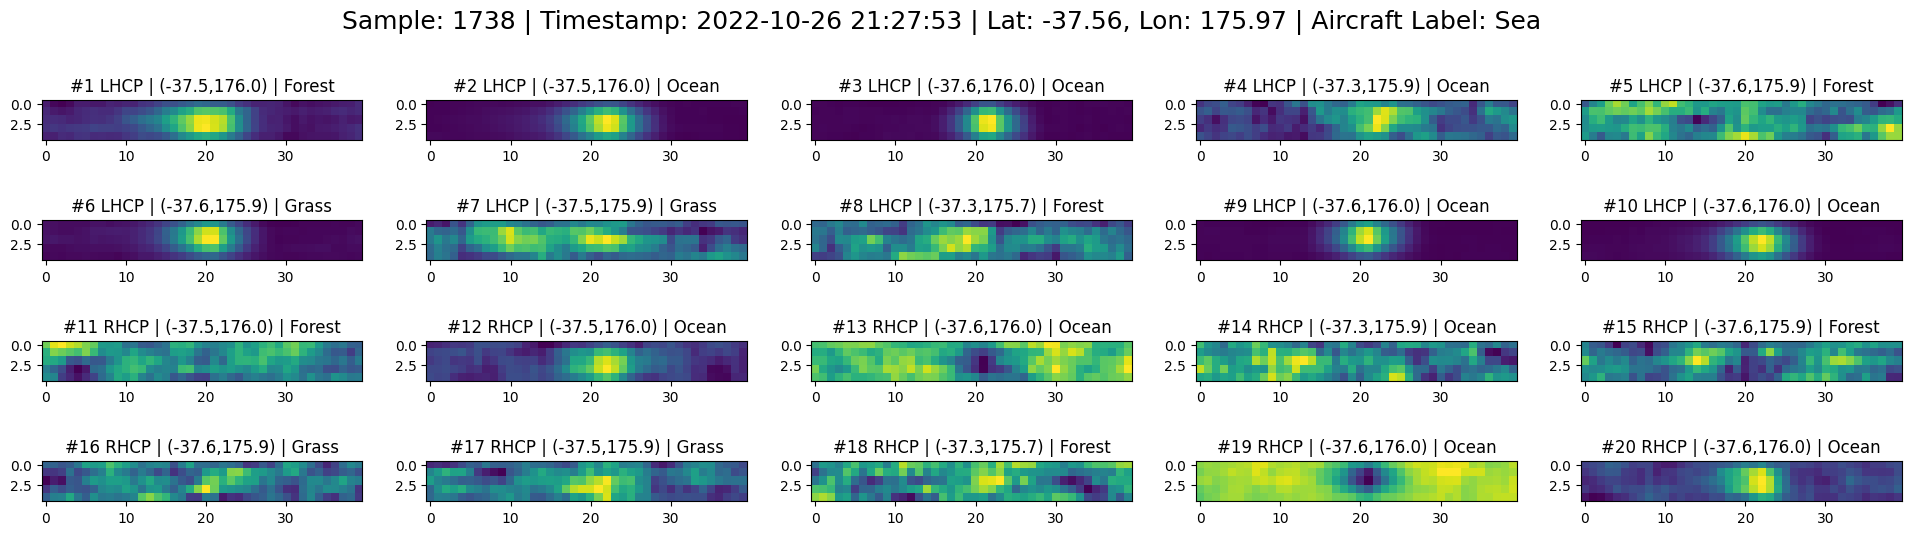

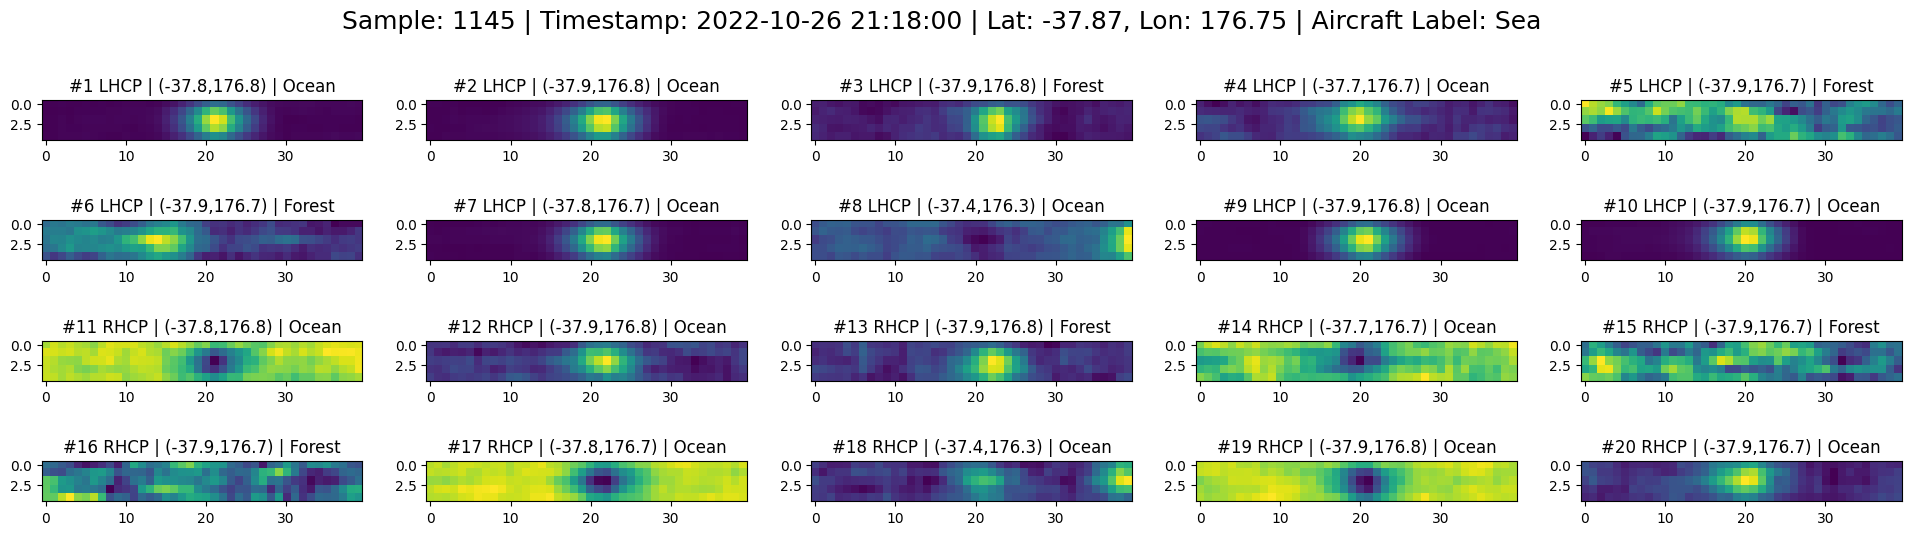

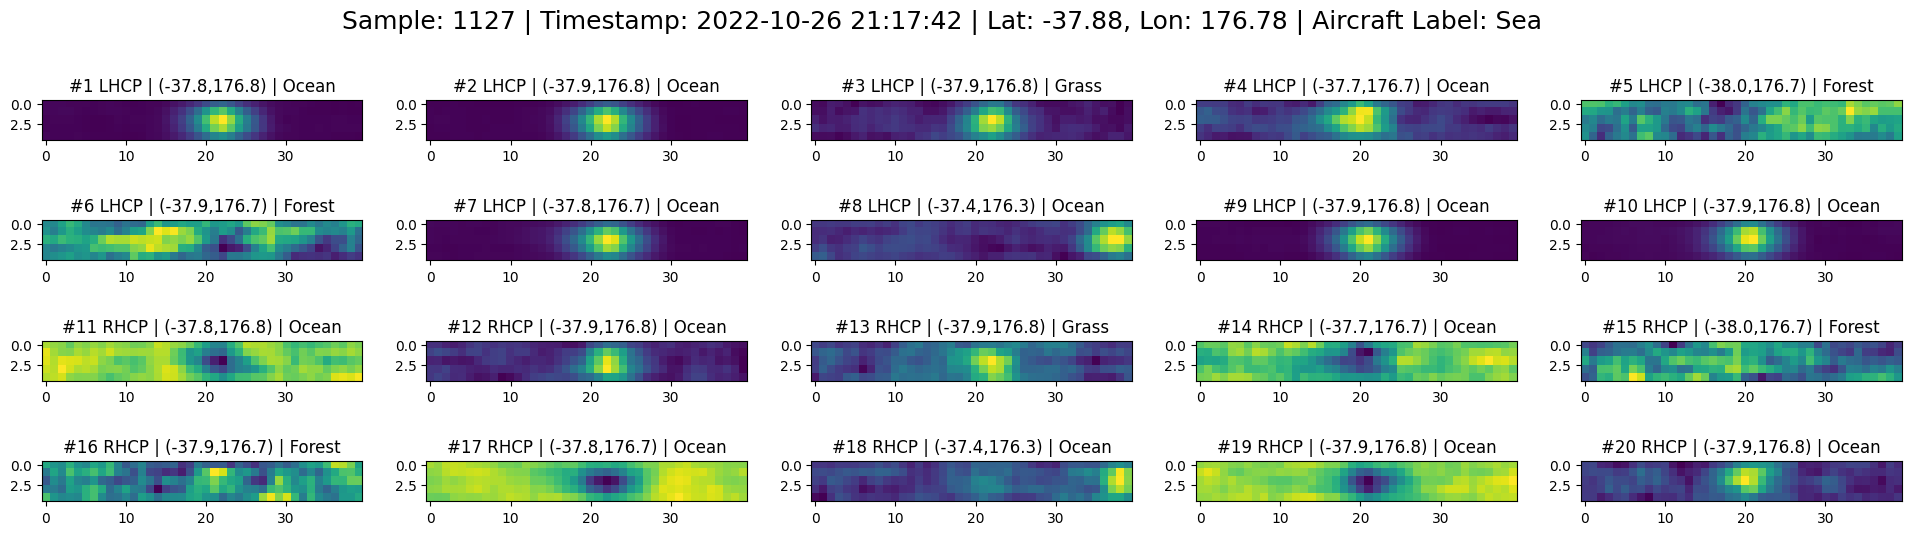

In [71]:
visualize = True

# Extracting and plotting DDMs
brcs = f.variables['brcs']
brcs = np.array(brcs)
print(brcs.shape)
print('Min:', np.nanmin(brcs))
print('Max:', np.nanmax(brcs))
print('NaNs:', np.count_nonzero(np.isnan(brcs)), '({:.2f}%)'.format(np.count_nonzero(np.isnan(brcs))/brcs.size*100))

if visualize:
    
    for sample in samples:

        plt.figure(figsize=(24,6))
        plt.suptitle(f"Sample: {sample} | Timestamp: {add_seconds(str(f.time_coverage_start), sample)} | Lat: {np.round(lats[sample], 2)}, Lon: {np.round(lons[sample], 2)} | Aircraft Label: {'Land' if is_land(lats[sample], lons[sample]) else 'Sea'}", fontsize=18)

        for ddm in range(brcs.shape[1]):

            antenna = f.variables['ddm_ant'][sample][ddm]

            plt.subplot(4, 5, ddm+1)
            plt.imshow(brcs[sample, ddm].T)
            plt.title(f"#{ddm+1} {ddm_antennas[antenna]} | ({np.round(specular_point_lat[sample,ddm],1)},{np.round(specular_point_lon[sample,ddm],1)}) | {surface_type_dict[int(surface_types[sample,ddm])]}", fontsize=12)

        plt.show()

### EFF Scatter

5 x 40 array of DDM bin effective scattering area, m^2. This is an estimate of the true surface scattering area that contributes power to each DDM bin, after accounting for the GPS signal spreading function. It is calculated by convolving the GPS ambiguity function with the surface area that contributes power to a given DDM bin as determined by its delay and Doppler values and the measurement geometry. The specular point bin location matches the specular point bin location in brcs.

In [78]:
visualize = False

# Extracting and plotting DDMs
eff_scatter = f.variables['eff_scatter']
eff_scatter = np.array(eff_scatter)
print(eff_scatter.shape)
print('Min:', np.nanmin(eff_scatter))
print('Max:', np.nanmax(eff_scatter))
print('NaNs:', np.count_nonzero(np.isnan(eff_scatter)), '({:.2f}%)'.format(np.count_nonzero(np.isnan(eff_scatter))/eff_scatter.size*100))

if visualize:

    for sample in samples:

        plt.figure(figsize=(24,6))
        plt.suptitle(f"Sample: {sample} | Timestamp: {add_seconds(str(f.time_coverage_start), sample)} | Lat: {np.round(lats[sample], 2)}, Lon: {np.round(lons[sample], 2)} | Aircraft Label: {'Land' if is_land(lats[sample], lons[sample]) else 'Sea'}", fontsize=18)

        for ddm in range(eff_scatter.shape[1]):

            antenna = f.variables['ddm_ant'][sample][ddm]

            plt.subplot(4, 5, ddm+1)
            plt.imshow(eff_scatter[sample, ddm].T)
            plt.title(f"#{ddm+1} {ddm_antennas[antenna]} | ({np.round(specular_point_lat[sample,ddm],1)},{np.round(specular_point_lon[sample,ddm],1)}) | {surface_type_dict[int(surface_types[sample,ddm])]}", fontsize=12)

        plt.show()

(2746, 20, 40, 5)
Min: -134582.97
Max: 57760580.0
NaNs: 2287600 (20.83%)


### Surface Reflectivity

5 x 40 array of DDM reflectivity of illuminated DDM surface.

In [79]:
visualize = False

# Extracting and plotting DDMs
surface_reflectivity = f.variables['surface_reflectivity']
surface_reflectivity = np.array(surface_reflectivity)
print(surface_reflectivity.shape)
print('Min:', np.nanmin(surface_reflectivity))
print('Max:', np.nanmax(surface_reflectivity))
print('NaNs:', np.count_nonzero(np.isnan(surface_reflectivity)), '({:.2f}%)'.format(np.count_nonzero(np.isnan(surface_reflectivity))/surface_reflectivity.size*100))

if visualize:

    for sample in samples:

        plt.figure(figsize=(24,6))
        plt.suptitle(f"Sample: {sample} | Timestamp: {add_seconds(str(f.time_coverage_start), sample)} | Lat: {np.round(lats[sample], 2)}, Lon: {np.round(lons[sample], 2)} | Aircraft Label: {'Land' if is_land(lats[sample], lons[sample]) else 'Sea'}", fontsize=18)

        for ddm in range(surface_reflectivity.shape[1]):

            antenna = f.variables['ddm_ant'][sample][ddm]

            plt.subplot(4, 5, ddm+1)
            plt.imshow(surface_reflectivity[sample, ddm].T)
            plt.title(f"#{ddm+1} {ddm_antennas[antenna]} | ({np.round(specular_point_lat[sample,ddm],1)},{np.round(specular_point_lon[sample,ddm],1)}) | {surface_type_dict[int(surface_types[sample,ddm])]}", fontsize=12)

        plt.show()

(2746, 20, 40, 5)
Min: -20.33951
Max: 25.468342
NaNs: 50800 (0.46%)


### Dimensionality reduction

Investigate Land vs Water DDMs - Aircraft Path (perhaps not useful)

In [80]:
# Funzione per riempire, data la matrice totale (N, M, P, Q), per ogni campione N, le matrici (P, Q) completamente NaN con la media delle matrici (M, P, Q) non nulle
# Se tutte e M le matrici sono nulle, scarto il campione
def fill_and_filter(arr):
    mask_all_nan = np.all(np.isnan(arr), axis=(2, 3))  # Shape (N, M), True se la matrice è tutta NaN

    arr_filled = arr.copy()  # Facciamo una copia per non modificare l'originale

    for i in range(arr.shape[0]):  # Iteriamo sui campioni
        nan_indices = np.where(mask_all_nan[i])[0]  # Indici delle matrici M completamente NaN
        if len(nan_indices) > 0:  
            # Troviamo una matrice valida da cui prendere la media
            valid_indices = np.where(~mask_all_nan[i])[0]  
            if len(valid_indices) > 0:
                mean_matrix = np.nanmean(arr[i, valid_indices, :, :], axis=0)  # Media sulle matrici valide
                arr_filled[i, nan_indices, :, :] = mean_matrix  # Riempimento
            # Se tutte le matrici M di un campione sono NaN, lo segneremo per l'eliminazione

    # Identificare i campioni da eliminare (se TUTTE le matrici M sono NaN)
    mask_discard = np.all(mask_all_nan, axis=1)  
    arr_filtered = arr_filled[~mask_discard]  # Manteniamo solo i campioni validi

    return arr_filtered, list(np.where(mask_discard.astype(int) == 1)[0])

In [81]:
ddm_data_dict = {
        'L1a Power DDM': l1a_power_ddm,
        'BRCS': brcs,
        'Raw Counts': raw_counts,
        'Effective Scatter': eff_scatter,
        'Surface Reflectivity': surface_reflectivity
    }

In [82]:
fit_data, discard_indices = fill_and_filter(ddm_data_dict['Raw Counts'])


In [83]:
fit_data.shape

(2746, 20, 40, 5)

In [84]:

    
fit_data = fit_data.reshape(fit_data.shape[0], -1)
fit_data.shape

(2746, 4000)

In [ ]:
# Using aircraft position as sea/land labelling function

do_pca_and_classification = True

if do_pca_and_classification:

    ddm_data_dict = {
        'L1a Power DDM': l1a_power_ddm,
        'BRCS': brcs,
        'Raw Counts': raw_counts,
        'Effective Scatter': eff_scatter,
        'Surface Reflectivity': surface_reflectivity
    }

    plt.figure(figsize=(12, 12))
    plt.suptitle('2D PCA Projections of 20-per-sample DDMs')

    for q,quantity in enumerate(ddm_data_dict):

        print("----------------------------------")
        print(f"\n{quantity}")

        # Select, filter and normalize data
        scaler = MinMaxScaler()
        fit_data, discard_indices = fill_and_filter(ddm_data_dict[quantity])
        fit_data = fit_data.reshape(fit_data.shape[0], -1)
        fit_data = scaler.fit_transform(fit_data)
        print(f"Input data shape: {ddm_data_dict[quantity].shape}")
        print(f"Filtered data shape: {fit_data.shape}")
        print(f"Discarded samples: {len(discard_indices)}")

        # Land vs Water labels (same for all variables)
        label_data = [1 if is_land(lat, lon) else 0 for lat, lon in zip(lats, lons)]
        label_data = [label_data[l] for l in range(len(label_data)) if l not in discard_indices]
        print(f"Label data shape: {len(label_data)}")

        # Fit PCA and transform
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(fit_data)
        pca_land = np.array([pca_data[f] for f in range(len(pca_data)) if label_data[f] == 1])
        pca_water = np.array([pca_data[f] for f in range(len(pca_data)) if label_data[f] == 0])

        plt.subplot(3, 2, q+1)
        plt.scatter(pca_land[:, 0], pca_land[:, 1], c='forestgreen', s=8, label='Land')
        plt.scatter(pca_water[:, 0], pca_water[:, 1], c='lightseagreen', s=8, label='Water')
        plt.grid(alpha=0.3)
        plt.legend()
        plt.title(quantity)

        # Fit Random Forest Classifier
        X_train, X_test, y_train, y_test = train_test_split(fit_data, np.array(label_data), test_size=0.2, random_state=42, stratify=label_data)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        train_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)
        print(f"Random Forest training accuracy: {train_accuracy:.2f}")
        print(f"Random Forest test accuracy: {test_accuracy:.2f}")

    plt.show()


Investigate Land vs Water DDMs - DDM Specular Points

In [ ]:
# Using DDM SP position as sea/land labelling function

do_pca_and_classification = True

if do_pca_and_classification:

    # Input data
    ddm_data_dict = {
        'L1a Power DDM': l1a_power_ddm.reshape(l1a_power_ddm.shape[0]*l1a_power_ddm.shape[1], l1a_power_ddm.shape[2], l1a_power_ddm.shape[3]),
        'BRCS': brcs.reshape(brcs.shape[0]*brcs.shape[1], brcs.shape[2], brcs.shape[3]),
        'Raw Counts': raw_counts.reshape(raw_counts.shape[0]*raw_counts.shape[1], raw_counts.shape[2], raw_counts.shape[3]),
        'Effective Scatter': eff_scatter.reshape(eff_scatter.shape[0]*eff_scatter.shape[1], eff_scatter.shape[2], eff_scatter.shape[3]),
        'Surface Reflectivity': surface_reflectivity.reshape(surface_reflectivity.shape[0]*surface_reflectivity.shape[1], surface_reflectivity.shape[2], surface_reflectivity.shape[3])
    }
    # Target variable
    surface_types_unravelled = surface_types.ravel()

    # PCA and RF for all quantities
    for q,quantity in enumerate(ddm_data_dict):

        print("----------------------------------")
        print(f"\n{quantity}")

        # Select, filter and normalize data
        scaler = MinMaxScaler()
        current_data = ddm_data_dict[quantity]
        keep_indices = np.where(
            np.all(~np.isnan(current_data), axis=(1, 2)) & (np.sum(current_data, axis=(1, 2)) > 0)
        )[0] # remove nan ddms and ddms which are all zeros (esp. for raw counts)
        fit_data = np.array([ddm_data_dict[quantity][f].ravel() for f in keep_indices])
        fit_data = scaler.fit_transform(fit_data)
        print(f"Input data shape: {ddm_data_dict[quantity].shape}")
        print(f"Filtered data shape: {fit_data.shape}")
        print(f"Valid samples: {len(keep_indices)}")

        # Land vs Water labels (same for all variables)
        label_data = [1 if surface_type in np.arange(1,8) else 0 for surface_type in surface_types_unravelled]
        label_data = [label_data[l] for l in range(len(label_data)) if l in keep_indices]
        print(f"Label data shape: {len(label_data)}")

        # Fit PCA and transform
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(fit_data)
        pca_land = np.array([pca_data[f] for f in range(len(pca_data)) if label_data[f] == 1])
        pca_water = np.array([pca_data[f] for f in range(len(pca_data)) if label_data[f] == 0])

        #plt.subplot(3, 2, q+1)
        plt.figure(figsize=(6,4))
        plt.scatter(pca_land[:, 0], pca_land[:, 1], c='forestgreen', s=8, label='Land')
        plt.scatter(pca_water[:, 0], pca_water[:, 1], c='lightseagreen', s=8, label='Water')
        plt.grid(alpha=0.3)
        plt.legend()
        plt.title(quantity)
        plt.show()

        # Fit Random Forest Classifier on the full dataset
        X_train, X_test, y_train, y_test = train_test_split(fit_data, np.array(label_data), test_size=0.2, random_state=42, stratify=label_data)
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        train_accuracy = clf.score(X_train, y_train)
        test_accuracy = clf.score(X_test, y_test)
        print(f"Random Forest training accuracy: {train_accuracy:.2f}")
        print(f"Random Forest test accuracy: {test_accuracy:.2f}")


## Create Pandas Dataframe

Expected row count is 20 * number of timestamps.

Useful variables:
- ddm_timestamp_utc: sample timestamp
- ddm: number of channel acquiring i-th DDM at sample timestamp (1 through 20)
- ddm_ant: name of antenna acquiring i-th DDM at sample timestamp
- ac_alt: aircraft altitude at sample timestamp
- ac_lat: aircraft latitude at sample timestamp
- ac_lon: aircraft longitude at sample timestamp
- ddm_snr: signal to noise ratio of i-th DDM at sample timestamp
- ddm_noise_floor: noise floor of i-th DDM at sample timestamp
- fresnel_major: length of the major axis of the first Fresnel zone
- fresnel_minor: length of the minor axis of the first Fresnel zone
- fresnel_orientation: the angle between the major axis and the North
- sp_alt: altitude of the Specular point relative to the WGS 84 datum in meters
- sp_lat: Specular point latitude
- sp_lon: Specular point longitude
- sp_inc_angle: angle between the line normal to the Earth's surface at the specular point and the line extending from the specular point to the aircraft.
- sp_surface_type: surface type of the specular point, surface type from the latest LINZ database

### Dataframe creation

In [40]:
# Create dataframe with relevant information about DDMs

df = pd.DataFrame()

for i in tqdm(range(f.variables['ddm_timestamp_utc'][:].shape[0])):
    df_subset = {
        'Timestamp': np.repeat(add_seconds(str(f.time_coverage_start), int(f.variables['ddm_timestamp_utc'][i])), 20),
        'DDM Channel': f.variables['ddm'][:],
        'DDM Antenna': f.variables['ddm_ant'][i],
        'Aircraft altitude': np.repeat(int(f.variables['ac_alt'][i]), 20),
        'Aircraft latitude': np.repeat(f.variables['ac_lat'][i], 20),
        'Aircraft longitude': np.repeat(f.variables['ac_lon'][i], 20),
        'Specular point altitude': f.variables['sp_alt'][i],
        'Specular point latitude': f.variables['sp_lat'][i],
        'Specular point longitude': f.variables['sp_lon'][i],
        'Specular point incidence angle': f.variables['sp_inc_angle'][i],
        'Surface type': f.variables['sp_surface_type'][i],
        'Fresnel major axis': f.variables['fresnel_major'][i],
        'Fresnel minor axis': f.variables['fresnel_minor'][i],
        'Fresnel orientation': f.variables['fresnel_orientation'][i],
        'DDM SNR': f.variables['ddm_snr'][i],
        'DDM noise floor': f.variables['ddm_noise_floor'][i],
    }
    df = pd.concat([df, pd.DataFrame(df_subset)], axis=0, ignore_index=True)

df.head()

100%|██████████| 2746/2746 [00:25<00:00, 108.04it/s]


,Timestamp,DDM Channel,DDM Antenna,Aircraft altitude,Aircraft latitude,Aircraft longitude,Specular point altitude,Specular point latitude,Specular point longitude,Specular point incidence angle,Surface type,Fresnel major axis,Fresnel minor axis,Fresnel orientation,DDM SNR,DDM noise floor
0,2022-10-26 20:58:55,0,0,911,-38.605809,177.900433,15.999914,-38.604389,177.902621,15.062627,4.0,NaN,NaN,NaN,NaN,62396944.0
1,2022-10-26 20:58:55,1,0,911,-38.605809,177.900433,10.999941,-38.611608,177.908605,46.614464,5.0,NaN,NaN,NaN,NaN,62396944.0
2,2022-10-26 20:58:55,2,0,911,-38.605809,177.900433,55.999699,-38.580177,177.893151,72.466492,5.0,NaN,NaN,NaN,NaN,62396944.0
3,2022-10-26 20:58:55,3,0,911,-38.605809,177.900433,14.999920,-38.608294,177.889559,47.329388,4.0,NaN,NaN,NaN,NaN,62396944.0
4,2022-10-26 20:58:55,4,0,911,-38.605809,177.900433,60.999672,-38.588471,177.885023,68.627106,5.0,NaN,NaN,NaN,NaN,62396944.0


### SP distance from the aircraft

In [42]:
# SP incidence angle and distance computation
print(f.variables['sp_inc_angle'].comment)
#print(f'SP incidence angle ranges: {np.round(float(np.nanmin(f.variables['sp_inc_angle'][:])),3)}, {np.round(float(np.nanmax(f.variables['sp_inc_angle'][:])),3)}')
img = mpimg.imread('D:\GREAT\docs\images\SP_aircraft_distance.png')
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.axis(False)
plt.show()

The Specular point incidence angle, in degrees, at ddm_timestamp_utc. This is the angle between the line normal to the Earth's surface at the specular point and the line extending from the specular point to the aircraft.


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\GREAT\\docs\\images\\SP_aircraft_distance.png'

In [43]:
# Compute distance between aircraft and DDM specular point
df['DDM SP distance at ground-level'] = (df['Aircraft altitude'] - df['Specular point altitude']) * (np.sin(df['Specular point incidence angle']* np.pi / 180.)/np.cos(df['Specular point incidence angle']* np.pi / 180.)) # distance l
df['DDM SP distance from aircraft'] = (df['Aircraft altitude'] - df['Specular point altitude'])/np.cos(df['Specular point incidence angle']* np.pi / 180.) # distance d

df.head()

,Timestamp,DDM Channel,DDM Antenna,Aircraft altitude,Aircraft latitude,Aircraft longitude,Specular point altitude,Specular point latitude,Specular point longitude,Specular point incidence angle,Surface type,Fresnel major axis,Fresnel minor axis,Fresnel orientation,DDM SNR,DDM noise floor,DDM SP distance at ground-level,DDM SP distance from aircraft
0,2022-10-26 20:58:55,0,0,911,-38.605809,177.900433,15.999914,-38.604389,177.902621,15.062627,4.0,NaN,NaN,NaN,NaN,62396944.0,240.863390,926.844293
1,2022-10-26 20:58:55,1,0,911,-38.605809,177.900433,10.999941,-38.611608,177.908605,46.614464,5.0,NaN,NaN,NaN,NaN,62396944.0,952.204862,1310.226818
2,2022-10-26 20:58:55,2,0,911,-38.605809,177.900433,55.999699,-38.580177,177.893151,72.466492,5.0,NaN,NaN,NaN,NaN,62396944.0,2706.194561,2838.047706
3,2022-10-26 20:58:55,3,0,911,-38.605809,177.900433,14.999920,-38.608294,177.889559,47.329388,4.0,NaN,NaN,NaN,NaN,62396944.0,971.985911,1321.957935
4,2022-10-26 20:58:55,4,0,911,-38.605809,177.900433,60.999672,-38.588471,177.885023,68.627106,5.0,NaN,NaN,NaN,NaN,62396944.0,2171.969763,2332.370677


In [ ]:
# Specular point distances from aircraft

var = 'DDM SP distance from aircraft' # 'DDM SP distance at ground-level'

print(np.percentile(df[var].dropna(), 100))

clipped_values = np.clip(df[var].values, 0, np.percentile(df[var].dropna(), 95))
sorted_data = np.sort(clipped_values)
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(12,6))

plt.suptitle(f'{var} (clipped at 95th percentile)', fontsize=16)

plt.subplot(1,2,1)
plt.hist(clipped_values, bins=100, density=True)
plt.xticks(np.arange(0, np.percentile(df[var].dropna(), 95), 10000), rotation=45)
plt.xlabel('Distance (m)')
plt.ylabel('Density')
plt.title('Histogram')
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(sorted_data, cdf, marker='.', linestyle='none', c='red', linewidth=1)
plt.xticks(np.arange(0, np.percentile(df[var].dropna(), 95), 10000), rotation=45)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('Distance (m)')
plt.ylabel('CDF')
plt.title('Cumulative Distribution Function')
plt.grid(alpha=0.4)

plt.show()

In [ ]:
# plot DDM specular points coloured by distance from aircraft

ac_lat = f.variables['ac_lat'][:].ravel()
ac_lon = f.variables['ac_lon'][:].ravel()

sp_lat = f.variables['sp_lat'][:].ravel()
sp_lon = f.variables['sp_lon'][:].ravel()

min_lat, max_lat = float(np.nanmin(sp_lat)), float(np.nanmax(sp_lat))
min_lon, max_lon = float(np.nanmin(sp_lon)), float(np.nanmax(sp_lon)) 

# Calcoliamo i terzili delle distanze
q1, q2 = np.percentile(df['DDM SP distance from aircraft'].dropna().values, [33, 66])

# Assegniamo i colori in base alle soglie
colori = np.where(df['DDM SP distance from aircraft'].values <= q1, 'blue',  # Primo terzile
         np.where(df['DDM SP distance from aircraft'].values <= q2, 'orange',  # Secondo terzile
                  'red'))  # Terzo terzile

# Creare la figura con una proiezione geografica
fig, ax = plt.subplots(1, 2, figsize=(17,9))

######### MAP

# Aggiungere le caratteristiche della mappa
pad = 1
ax[0] = plt.subplot(1,2,1, projection=ccrs.PlateCarree())
ax[0].set_extent([min_lon-pad, max_lon+pad, min_lat-pad, max_lat+pad], crs=ccrs.PlateCarree())
ax[0].add_feature(cfeature.OCEAN, facecolor="lightblue")
ax[0].add_feature(cfeature.LAND, edgecolor="black", facecolor="lightgray")
ax[0].add_feature(cfeature.COASTLINE)

# Disegnare la rotta
ax[0].scatter(sp_lon, sp_lat, marker="o", color=colori, s=1, linewidth=1, transform=ccrs.PlateCarree())
ax[0].scatter(ac_lon, ac_lat, marker="o", color='black', s=2, linewidth=1, transform=ccrs.PlateCarree())

# Etichettare inizio e fine
ax[0].text(sp_lon[np.where(~np.isnan(sp_lon))][0], sp_lat[np.where(~np.isnan(sp_lat))][0], "Start", color="black", fontsize=9, transform=ccrs.PlateCarree(),
        bbox=dict(facecolor="lightgreen", edgecolor="black", boxstyle="round,pad=0.3"))
ax[0].text(sp_lon[np.where(~np.isnan(sp_lon))][-1], sp_lat[np.where(~np.isnan(sp_lat))][-1], "End", color="black", fontsize=9, transform=ccrs.PlateCarree(),
        bbox=dict(facecolor="salmon", edgecolor="black", boxstyle="round,pad=0.3"))
ax[0].set_title("SP distances from aircraft", fontsize=16)

# Creiamo la legenda con le patches
legend_patches = [
    mpatches.Patch(color='blue', label=f'Distanza ≤ {q1:.2f}m'),
    mpatches.Patch(color='orange', label=f'{q1:.2f}m < Distanza ≤ {q2:.2f}m'),
    mpatches.Patch(color='red', label=f'Distanza > {q2:.2f}m'),
    mpatches.Patch(color='black', label='Aircraft path')
]

# Aggiungiamo la legenda
ax[0].legend(handles=legend_patches, loc='lower right', fontsize=9)

######### ALTITUDE

ax[1].plot(range(len(f.variables['ac_alt'][:])), f.variables['ac_alt'][:], c='black', linewidth=3)
ax[1].grid(alpha=0.4)
ax[1].set_xlabel('Timestamp (sample)')
ax[1].set_ylabel('Altitude (m)')
ax[1].set_title('Aircraft altitude during flight', fontsize=16)

# Mostrare la mappa
plt.show()

In [ ]:
# check computations
data = df[['DDM SP distance at ground-level', 'DDM SP distance from aircraft']].dropna(axis=0)
data['Aircraft altitude - SP altitude'] = np.abs(df['Aircraft altitude'] - df['Specular point altitude']).dropna(axis=0)
data['Hypotenuse'] = np.sqrt(data['DDM SP distance at ground-level']**2 + data['Aircraft altitude - SP altitude']**2)
data

### SNR

In [ ]:
data = df[['DDM SNR', 'DDM SP distance at ground-level', 'DDM SP distance from aircraft', 'Aircraft altitude', 'Surface type']].dropna(axis=0)
print(f'\nAverage SNR: {np.mean(data['DDM SNR'])} ({np.std(data['DDM SNR'])})')
print(f'Average SNR over Sea: {np.mean(data[data['Surface type']==-1]['DDM SNR'])} ({np.std(data[data['Surface type']==-1]['DDM SNR'])})')
print(f'Average SNR over Land: {np.mean(data[data['Surface type']>-1]['DDM SNR'])} ({np.std(data[data['Surface type']>-1]['DDM SNR'])})')

print('\nCorrelation coefficient between DDM SNR and DDM distance:')
print('Aircraft projection on the sea surface:', float(np.corrcoef(data['DDM SNR'], data['DDM SP distance at ground-level'])[0,1]))
print('Aircraft distance:', float(np.corrcoef(data['DDM SNR'], data['DDM SP distance from aircraft'])[0,1]))
print('Aircraft altitude:', float(np.corrcoef(data['DDM SNR'], data['Aircraft altitude'])[0,1]))

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.scatter(data['DDM SP distance at ground-level'], data['DDM SNR'], s=2, c='silver')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['DDM SP distance at ground-level'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Distance (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs DDM SP distance at ground-level')
plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(data['DDM SP distance from aircraft'], data['DDM SNR'], s=2, c='silver')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['DDM SP distance from aircraft'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Distance (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs DDM SP distance from aircraft')
plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(data['Aircraft altitude'], data['DDM SNR'], s=2, c='silver')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['Aircraft altitude'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Altitude (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs Aircraft altitude')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Correlation analysis on water spots

data = df[['DDM SNR', 'DDM SP distance at ground-level', 'DDM SP distance from aircraft', 'Aircraft altitude', 'Surface type']].dropna(axis=0)
data = data[data['Surface type'] == -1]

print('Correlation coefficient between DDM SNR and DDM distance:')
print('Aircraft projection on the sea surface:', float(np.corrcoef(data['DDM SNR'], data['DDM SP distance at ground-level'])[0,1]))
print('Aircraft distance:', float(np.corrcoef(data['DDM SNR'], data['DDM SP distance from aircraft'])[0,1]))
print('Aircraft altitude:', float(np.corrcoef(data['DDM SNR'], data['Aircraft altitude'])[0,1]))

print(f'\nAverage SNR: {np.mean(data['DDM SNR'])} ({np.std(data['DDM SNR'])})')

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.scatter(data['DDM SP distance at ground-level'], data['DDM SNR'], s=2, c='tab:blue')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['DDM SP distance at ground-level'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Distance (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs DDM SP distance at ground-level')
plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(data['DDM SP distance from aircraft'], data['DDM SNR'], s=2, c='tab:blue')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['DDM SP distance from aircraft'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Distance (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs DDM SP distance from aircraft')
plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(data['Aircraft altitude'], data['DDM SNR'], s=2, c='tab:blue')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['Aircraft altitude'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Altitude (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs Aircraft altitude')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
# Correlation analysis on land spots

data = df[['DDM SNR', 'DDM SP distance at ground-level', 'DDM SP distance from aircraft', 'Aircraft altitude', 'Surface type']].dropna(axis=0)
data = data[data['Surface type'] > -1]

print('Correlation coefficient between DDM SNR and DDM distance:')
print('Aircraft projection on the sea surface:', float(np.corrcoef(data['DDM SNR'], data['DDM SP distance at ground-level'])[0,1]))
print('Aircraft distance:', float(np.corrcoef(data['DDM SNR'], data['DDM SP distance from aircraft'])[0,1]))
print('Aircraft altitude:', float(np.corrcoef(data['DDM SNR'], data['Aircraft altitude'])[0,1]))

print(f'\nAverage SNR: {np.mean(data['DDM SNR'])} ({np.std(data['DDM SNR'])})')

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.scatter(data['DDM SP distance at ground-level'], data['DDM SNR'], s=2, c='tab:green')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['DDM SP distance at ground-level'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Distance (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs DDM SP distance at ground-level')
plt.grid(alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(data['DDM SP distance from aircraft'], data['DDM SNR'], s=2, c='tab:green')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['DDM SP distance from aircraft'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Distance (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs DDM SP distance from aircraft')
plt.grid(alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(data['Aircraft altitude'], data['DDM SNR'], s=2, c='tab:green')
plt.hlines(y=0, xmin=0, xmax=np.percentile(data['Aircraft altitude'], 100), color='red', linewidth=3, linestyle='-')
plt.xlabel('Altitude (m)')
plt.ylabel('DDM SNR')
plt.title('DDM SNR vs Aircraft altitude')
plt.grid(alpha=0.3)

plt.show()